# Import librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# lazy 
from lazypredict.Supervised import LazyClassifier
from sklearn.utils import all_estimators
from sklearn.base import ClassifierMixin

# search hyperparameters
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

# modèles 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier
from sklearn.svm import LinearSVC

import xgboost as xgb
import shap

# métriques 
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from sklearn.metrics import classification_report,accuracy_score, f1_score, fbeta_score,  average_precision_score
from sklearn.metrics import make_scorer, confusion_matrix, precision_score, recall_score, precision_recall_curve

# Rééchantillonage
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from imblearn.under_sampling import RandomUnderSampler

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# sauvegarde model
import pickle
import itertools
import os

# import des fonctions de modélisations
import  modeling_functions as mf




# Chargement données issues du preprocessing

In [15]:

# jeu de données issues du preprocessing mixte
df_V1 = pd.read_csv("../data_saved/df_final.csv", index_col=["id_Location","id_Date"])

# jeu de données issues du preprocessing successif
df_V2 =  pd.read_csv("../data_saved/data_preprocessed_V2.csv", index_col=["id_Location","id_Date"])

missing_percentages = df_V2.isna().mean()
threshold = 0.25
# Colonnes à conserver
columns_to_keep = missing_percentages[missing_percentages <= threshold].index
columns_dropped = missing_percentages[missing_percentages > threshold].index
df_V2 = df_V2[columns_to_keep]
print("Colonnes supprimées sur le df V2 :", columns_dropped)

print(missing_percentages.loc["Evaporation"])

# jeu de données avec des variables lags et en variation additionnelles
df_V3 =  pd.read_csv("../data_saved/data_preprocessed_V3.csv", index_col=["id_Location","id_Date"])


missing_percentages = df_V3.isna().mean()
threshold = 0.25
# Colonnes à conserver
columns_to_keep = missing_percentages[missing_percentages <= threshold].index
columns_dropped = missing_percentages[missing_percentages > threshold].index
df_V3 = df_V3[columns_to_keep]
print("Colonnes supprimées sur le df V3:", columns_dropped)


print("dimensions V1 :", df_V1.shape)
print("dimensions V2 :", df_V2.shape)
print("dimensions V3 :", df_V3.shape)

print("dimensions V1 sans Nas :", df_V1.dropna().shape)
print("dimensions V2 sans Nas:", df_V2.dropna().shape)
print("dimensions V3 sans Nas:", df_V3.dropna().shape)


Colonnes supprimées sur le df V2 : Index(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], dtype='object')
0.27965511663724657
Colonnes supprimées sur le df V3: Index(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'Evaporation_lag1',
       'Evaporation_lag2', 'Evaporation_lag3', 'Evaporation_mean3j',
       'Sunshine_lag1', 'Sunshine_lag2', 'Sunshine_lag3', 'Sunshine_mean3j',
       'Cloud_delta'],
      dtype='object')
dimensions V1 : (135600, 42)
dimensions V2 : (142193, 94)
dimensions V3 : (142193, 125)
dimensions V1 sans Nas : (135600, 42)
dimensions V2 sans Nas: (136222, 94)
dimensions V3 sans Nas: (123585, 125)


# Séparation en train et test 

In [3]:
# Version classique (random sur 20% des données)

X_train_V1, X_test_V1, y_train_V1, y_test_V1 = \
    mf.separation_train_test(df_V1, sep_method="classique")
X_train_V2, X_test_V2, y_train_V2, y_test_V2 = \
    mf.separation_train_test(df_V2, sep_method="classique")
X_train_V3, X_test_V3, y_train_V3, y_test_V3 = \
    mf.separation_train_test(df_V3, sep_method="classique")



In [4]:
# Version temporelle  : 
# train = premières années représentant environ 80 % des données
# test = années restantes

X_train_V1t, X_test_V1t, y_train_V1t, y_test_V1t = \
    mf.separation_train_test(df_V1, sep_method="temporelle")
X_train_V2t, X_test_V2t, y_train_V2t, y_test_V2t = \
    mf.separation_train_test(df_V2, sep_method="temporelle")
X_train_V3t, X_test_V3t, y_train_V3t, y_test_V3t = \
    mf.separation_train_test(df_V3, sep_method="temporelle")

Part des données par années  Date
2007   0.00
2008   0.02
2009   0.13
2010   0.25
2011   0.35
2012   0.46
2013   0.57
2014   0.70
2015   0.82
2016   0.94
2017   1.00
Name: count, dtype: float64
Séparation des données avant et après  2015
Part des données par années  Date
2007   0.00
2008   0.02
2009   0.13
2010   0.25
2011   0.35
2012   0.46
2013   0.57
2014   0.70
2015   0.82
2016   0.94
2017   1.00
Name: count, dtype: float64
Séparation des données avant et après  2015
Part des données par années  Date
2007   0.00
2008   0.02
2009   0.14
2010   0.25
2011   0.36
2012   0.46
2013   0.57
2014   0.69
2015   0.82
2016   0.94
2017   1.00
Name: count, dtype: float64
Séparation des données avant et après  2015


In [5]:
# Check les dimensions train et test

print(X_train_V1t.shape)
print(X_test_V1t.shape)
print(X_train_V2t.shape)
print(X_test_V2t.shape)
print(X_train_V3t.shape)
print(X_test_V3t.shape)



(94452, 39)
(41148, 39)
(94809, 92)
(41413, 92)
(85659, 124)
(37926, 124)


# Scaling

In [6]:
X_train_V1_scaled, X_test_V1_scaled = mf.scaling(X_train_V1, X_test_V1, scaler = MinMaxScaler())
X_train_V2_scaled, X_test_V2_scaled = mf.scaling(X_train_V2, X_test_V2, scaler = MinMaxScaler())
X_train_V3_scaled, X_test_V3_scaled = mf.scaling(X_train_V3, X_test_V3, scaler = MinMaxScaler())

X_train_V1t_scaled, X_test_V1t_scaled = mf.scaling(X_train_V1t, X_test_V1t, scaler = MinMaxScaler())
X_train_V2t_scaled, X_test_V2t_scaled = mf.scaling(X_train_V2t, X_test_V2t, scaler = MinMaxScaler())
X_train_V3t_scaled, X_test_V3t_scaled = mf.scaling(X_train_V3t, X_test_V3t, scaler = MinMaxScaler())


<Figure size 1000x1000 with 0 Axes>

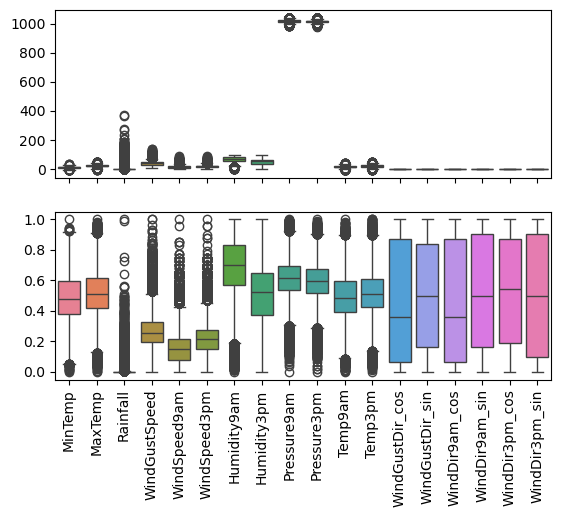

In [16]:
columns_check_scaling = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 
       'WindGustDir_cos', 'WindGustDir_sin', 'WindDir9am_cos',
       'WindDir9am_sin', 'WindDir3pm_cos', 'WindDir3pm_sin']
       
plt.figure(figsize = (10,10))
plt.subplots(ncols=1, nrows=2, sharex = True)
plt.subplot(211)
sns.boxplot(X_train_V2t.loc[:,columns_check_scaling ])
plt.xticks(rotation=90)
plt.subplot(212)
sns.boxplot(X_train_V2t_scaled.loc[:,columns_check_scaling ])
plt.xticks(rotation=90)
plt.show()


<Figure size 1000x3000 with 0 Axes>

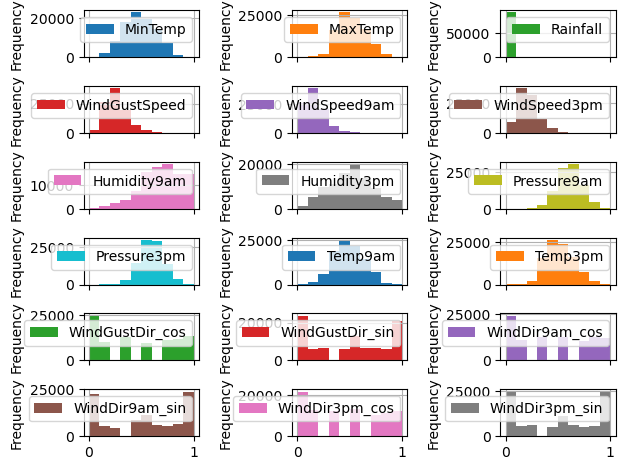

In [36]:
# check distribution après scaling

plt.figure(figsize = (10,30))
X_train_V2t_scaled.loc[:,columns_check_scaling ].\
    plot.hist(subplots = True, grid = True, layout=(6,3))

plt.tight_layout()
plt.show()



# Lazy predict 

In [23]:

removed_classifiers = [
"ClassifierChain",
"ComplementNB",
"GradientBoostingClassifier",
"GaussianProcessClassifier",
"HistGradientBoostingClassifier",
"MLPClassifier",
"LogisticRegressionCV",
"MultiOutputClassifier",
"MultinomialNB",
"OneVsOneClassifier",
"OneVsRestClassifier",
"OutputCodeClassifier",
"RadiusNeighborsClassifier",
"VotingClassifier",
'SVC','LabelPropagation','LabelSpreading','NuSV']


In [38]:
# warning, assez long (1-2 min par jeu de données)

print("Lazy predict, données V1")

models_V1t, predictions_V1t = mf.lazy_results(X_train_V1t_scaled, X_test_V1t_scaled, y_train_V1t, y_test_V1t)

print("Lazy predict, données V2")

models_V2t, predictions_V2t = mf.lazy_results(X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t, y_test_V2t)

print("Lazy predict, données V3")
models_V3t, predictions_V3t = mf.lazy_results(X_train_V3t_scaled, X_test_V3t_scaled, y_train_V3t, y_test_V3t)

models_V1t.to_csv("../modeling_results/lazy_predict_mixtepreprocessing_temp.csv",  decimal = ",")
models_V2t.to_csv("../modeling_results/lazy_predict_succereprocessing_temp.csv",  decimal = ",")
models_V3t.to_csv("../modeling_results/lazy_predict_V3process_temp.csv",  decimal = ",")




Lazy predict, données V1
'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 26/26 [00:58<00:00,  2.27s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.85,0.72,0.72,0.84,18.14
ExtraTreesClassifier,0.85,0.71,0.71,0.84,12.07
LinearDiscriminantAnalysis,0.84,0.72,0.72,0.83,0.72
LogisticRegression,0.84,0.72,0.72,0.83,0.35
CalibratedClassifierCV,0.84,0.71,0.71,0.83,2.61
BaggingClassifier,0.84,0.71,0.71,0.83,9.86
LinearSVC,0.84,0.71,0.71,0.83,0.77
AdaBoostClassifier,0.84,0.71,0.71,0.83,5.57
SGDClassifier,0.84,0.71,0.71,0.83,0.54


Lazy predict, données V2
'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 26/26 [01:24<00:00,  3.26s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.85,0.72,0.72,0.84,18.55
LogisticRegression,0.85,0.72,0.72,0.84,0.64
LinearDiscriminantAnalysis,0.85,0.72,0.72,0.84,1.33
ExtraTreesClassifier,0.85,0.71,0.71,0.83,15.69
LinearSVC,0.85,0.71,0.71,0.83,2.47
SGDClassifier,0.84,0.71,0.71,0.83,1.39
BaggingClassifier,0.84,0.71,0.71,0.83,15.07
RidgeClassifier,0.85,0.70,0.70,0.83,0.47
RidgeClassifierCV,0.85,0.70,0.70,0.83,1.00


Lazy predict, données V3
'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 26/26 [02:36<00:00,  6.02s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.85,0.73,0.73,0.84,0.82
LinearDiscriminantAnalysis,0.85,0.73,0.73,0.84,1.80
RandomForestClassifier,0.85,0.72,0.72,0.84,33.97
LinearSVC,0.85,0.72,0.72,0.84,2.75
RidgeClassifier,0.85,0.71,0.71,0.83,0.55
RidgeClassifierCV,0.85,0.71,0.71,0.83,1.44
SGDClassifier,0.84,0.72,0.72,0.83,1.95
ExtraTreesClassifier,0.85,0.70,0.70,0.83,18.55
AdaBoostClassifier,0.84,0.71,0.71,0.83,14.92


In [39]:
# Comparaison entre méthode classique et temporelle pour séparer les données 
# sur un modèle basique

models_select  = {
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1),
}

mf.fit_models(models_select, 
        X_train_V2_scaled, X_test_V2_scaled, y_train_V2, y_test_V2, 
        save_model = False, save_results=False)
mf.fit_models(models_select, 
        X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t, y_test_V2t, 
        save_model = False, save_results=False)

# Bilan, assez peu d'impacts

Fitting  RandomForestClassifier


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.87    0.96      0.92 31716.00
1.0                0.80    0.52      0.63  9151.00
accuracy           0.86    0.86      0.86     0.86
macro avg          0.84    0.74      0.77 40867.00
weighted avg       0.86    0.86      0.85 40867.00
Matrice de confusion :
       1.00  0.00
1.00  30500  1216
0.00   4402  4749
Fitting  RandomForestClassifier


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.87    0.96      0.91 32235.00
1.0                0.77    0.48      0.59  9178.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.82    0.72      0.75 41413.00
weighted avg       0.85    0.85      0.84 41413.00
Matrice de confusion :
       0.00  1.00
0.00  30939  1296
1.00   4775  4403


({'RandomForestClassifier':               precision  recall  f1-score  support
  0.0                0.87    0.96      0.91 32235.00
  1.0                0.77    0.48      0.59  9178.00
  accuracy           0.85    0.85      0.85     0.85
  macro avg          0.82    0.72      0.75 41413.00
  weighted avg       0.85    0.85      0.84 41413.00},
 {'RandomForestClassifier':        0.00  1.00
  0.00  30939  1296
  1.00   4775  4403},
 {'RandomForestClassifier': RandomForestClassifier(n_jobs=-1)})

# Fit modèles simples 

In [44]:
# Choix de 3 modèles 
models_select  = {
    'LogisticRegression': LogisticRegression(max_iter = 500, n_jobs=-1),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1),
    'BaggingClassifier': BaggingClassifier(n_estimators = 500, max_samples = 0.5,
                                           max_features = 0.5, n_jobs=-1),
    'LinearSVC'   : LinearSVC()                                    
}


In [45]:
# Test sur données preprocessed V1

report_V1t, cm_V1t, models_V1t = \
    mf.fit_models(
        models_select, 
        X_train_V1t_scaled, X_test_V1t_scaled, y_train_V1t, y_test_V1t, 
        save_model = True, save_models_dir="base_V1t_",
        save_results=True,save_results_dir="Base/base_V1t_")


Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier
Fitting  LinearSVC


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.89    0.90      0.89 32167.00
1.0                0.63    0.61      0.62  8981.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.76    0.75      0.76 41148.00
weighted avg       0.83    0.84      0.83 41148.00
Matrice de confusion :
       0.00  1.00
0.00  28878  3289
1.00   3490  5491


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.87    0.95      0.91 32167.00
1.0                0.75    0.49      0.59  8981.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.81    0.72      0.75 41148.00
weighted avg       0.84    0.85      0.84 41148.00
Matrice de confusion :
       0.00  1.00
0.00  30680  1487
1.00   4600 

In [46]:
# Test sur données preprocessed V2

report_V2t, cm_V2t, models_V2t = \
    mf.fit_models(models_select, 
               X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t, y_test_V2t,
               save_model = True, save_models_dir="base_V2t_",
               save_results=True,save_results_dir="Base/base_V2t_")



Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier
Fitting  LinearSVC


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.89    0.91      0.90 32235.00
1.0                0.66    0.59      0.62  9178.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.77    0.75      0.76 41413.00
weighted avg       0.84    0.84      0.84 41413.00
Matrice de confusion :
       0.00  1.00
0.00  29489  2746
1.00   3772  5406


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.87    0.96      0.91 32235.00
1.0                0.78    0.48      0.59  9178.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.82    0.72      0.75 41413.00
weighted avg       0.85    0.85      0.84 41413.00
Matrice de confusion :
       0.00  1.00
0.00  30996  1239
1.00   4785 

In [47]:
# Test sur données preprocessed V3

report_V3t, cm_V3t, models_V3t = \
    mf.fit_models(models_select, 
               X_train_V3t_scaled, X_test_V3t_scaled, y_train_V3t, y_test_V3t,
               save_model = True, save_models_dir="base_V3t_",
               save_results=True,save_results_dir="Base/base_V3t_")


Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier
Fitting  LinearSVC


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.88    0.94      0.91 29559.00
1.0                0.71    0.53      0.61  8367.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.80    0.74      0.76 37926.00
weighted avg       0.84    0.85      0.84 37926.00
Matrice de confusion :
       0.00  1.00
0.00  27778  1781
1.00   3907  4460


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.86    0.96      0.91 29559.00
1.0                0.78    0.47      0.58  8367.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.82    0.72      0.75 37926.00
weighted avg       0.85    0.85      0.84 37926.00
Matrice de confusion :
       0.00  1.00
0.00  28439  1120
1.00   4446 

   Dataset              model_name   Métrique value
0       V1      LogisticRegression     recall  0.61
1       V1  RandomForestClassifier     recall  0.49
2       V1       BaggingClassifier     recall  0.44
3       V1               LinearSVC     recall  0.62
4       V2      LogisticRegression     recall  0.59
5       V2  RandomForestClassifier     recall  0.48
6       V2       BaggingClassifier     recall  0.45
7       V2               LinearSVC     recall  0.58
8       V3      LogisticRegression     recall  0.53
9       V3  RandomForestClassifier     recall  0.47
10      V3       BaggingClassifier     recall  0.46
11      V3               LinearSVC     recall  0.49
12      V1      LogisticRegression  precision  0.63
13      V1  RandomForestClassifier  precision  0.75
14      V1       BaggingClassifier  precision  0.78
15      V1               LinearSVC  precision  0.62
16      V2      LogisticRegression  precision  0.66
17      V2  RandomForestClassifier  precision  0.78
18      V2  

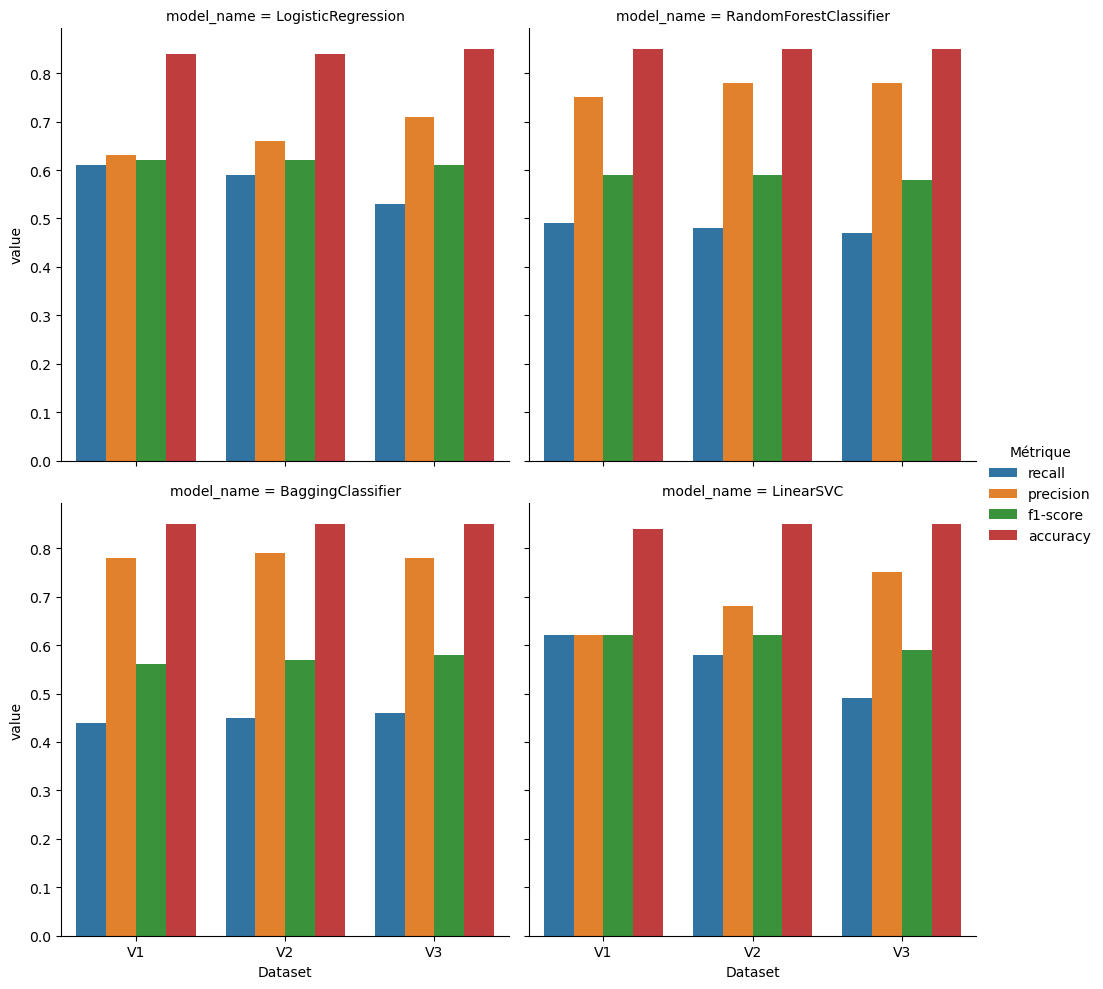

In [95]:
# Comparaison des preprocessing 

model_list = list(models_select.keys())
data_list = ['V1',"V2","V3"]
metrics_list = ["recall","precision","f1-score"]
class_label = "1.0"
index_results = list(itertools.product(data_list, model_list))
index_results = pd.MultiIndex.from_tuples(index_results , 
                                          names=["Dataset", "model_name"])

table_comp_preprocess = pd.DataFrame(index = 
                                     index_results, 
                                     columns=[metrics_list] )

table_comp_preprocess["accuracy"]=""

for model_name in model_list:
    table_comp_preprocess.loc[("V1",model_name),"accuracy"] = \
                report_V1t[model_name].loc["accuracy","precision"]
    
    table_comp_preprocess.loc[("V2",model_name),"accuracy"] = \
                report_V2t[model_name].loc["accuracy","precision"]
    
    table_comp_preprocess.loc[("V3",model_name),"accuracy"] = \
                report_V3t[model_name].loc["accuracy","precision"]
    
    for m in metrics_list:
        table_comp_preprocess.loc[("V1",model_name),m] = \
                report_V1t[model_name].loc[class_label,m]
        table_comp_preprocess.loc[("V2",model_name),m] = \
                report_V2t[model_name].loc[class_label,m]
        table_comp_preprocess.loc[("V3",model_name),m] = \
                report_V3t[model_name].loc[class_label,m]
        

table_comp_preprocess = table_comp_preprocess.reset_index()
table_comp_preprocess.columns = ["Dataset","model_name", "recall","precision","f1-score","accuracy"]

table_comp_preprocess = pd.melt(
    table_comp_preprocess,
        id_vars=["Dataset","model_name"],
        value_vars=["recall","precision","f1-score","accuracy"],
        var_name="Métrique")

print(table_comp_preprocess)


sns.catplot(data = table_comp_preprocess, x = "Dataset", y="value", 
            hue = "Métrique", col = "model_name", kind = "bar",
            col_wrap=2)

plt.savefig("../plots/rapport/comparaison_preprocessing.png")

# Rééchantillonage

In [96]:
# oversampling et fit sur données preprocessed V2

X_train_rs_V2t, y_train_rs_V2t = mf.resample(X_train_V2t,  y_train_V2t, resampler = SMOTE())
X_train_rs_V2t, X_test_V2t_scaled =  mf.scaling(X_train_rs_V2t, X_test_V2t, scaler=MinMaxScaler)

report_V2t, cm_V2t, models_V2t = \
    mf.fit_models(models_select, 
                  X_train_rs_V2t, X_test_V2t_scaled, y_train_rs_V2t, y_test_V2t,
                  save_model = True, save_models_dir="rs_V2t_",
                  save_results=True, save_results_dir="Resample/rs_V2t_")


Classes échantillon initial : {0.0: 73484, 1.0: 21325}
Classes échantillon rééchantillonné : {0.0: 73484, 1.0: 73484}
Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier
Fitting  LinearSVC


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                1.00    0.00      0.00 32235.00
1.0                0.22    1.00      0.36  9178.00
accuracy           0.22    0.22      0.22     0.22
macro avg          0.61    0.50      0.18 41413.00
weighted avg       0.83    0.22      0.08 41413.00
Matrice de confusion :
      0.00   1.00
0.00    17  32218
1.00     0   9178


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.90    0.90      0.90 32235.00
1.0                0.65    0.63      0.64  9178.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.77    0.77      0.77 41413.00
weig

In [97]:
# undersampling et fit sur données preprocessed V2
X_train_rs_V2t, y_train_rs_V2t = mf.resample(X_train_V2t,  y_train_V2t, resampler = RandomUnderSampler())
X_train_rs_V2t, X_test_V2t_scaled = mf.scaling(X_train_rs_V2t, X_test_V2t, scaler=MinMaxScaler)

report_V2t, cm_V2t, models_V2t = \
    mf.fit_models(models_select, 
                  X_train_rs_V2t, X_test_V2t_scaled, y_train_rs_V2t, y_test_V2t,
                  save_model = True, save_models_dir="rsunder_V2t_",
                  save_results=True, save_results_dir="Resample/rsunder_V2t_")


Classes échantillon initial : {0.0: 73484, 1.0: 21325}
Classes échantillon rééchantillonné : {0.0: 21325, 1.0: 21325}
Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier
Fitting  LinearSVC


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.93    0.74      0.82 32235.00
1.0                0.47    0.81      0.60  9178.00
accuracy           0.75    0.75      0.75     0.75
macro avg          0.70    0.78      0.71 41413.00
weighted avg       0.83    0.75      0.77 41413.00
Matrice de confusion :
       0.00  1.00
0.00  23757  8478
1.00   1699  7479


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.92    0.82      0.87 32235.00
1.0                0.54    0.76      0.64  9178.00
accuracy           0.81    0.81      0.81     0.81
macro avg          0.73    0.79      0.75 41413.00
weig

In [98]:
# combinaison over et under sampling et fit sur données preprocessed V2
X_train_rs_V2t, y_train_rs_V2t = mf.resample(X_train_V2t,  y_train_V2t, resampler = SMOTETomek())
X_train_rs_V2t, X_test_V2t_scaled = mf.scaling(X_train_rs_V2t, X_test_V2t, scaler=MinMaxScaler)

report_V2t, cm_V2t, models_V2t = \
    mf.fit_models(models_select, 
                  X_train_rs_V2t, X_test_V2t_scaled, y_train_rs_V2t, y_test_V2t,
                  save_model = True, save_models_dir="rssmotek_V2t_",
                  save_results=True, save_results_dir="Resample/rssmotek_V2t_")


Classes échantillon initial : {0.0: 73484, 1.0: 21325}
Classes échantillon rééchantillonné : {0.0: 73194, 1.0: 73194}
Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier
Fitting  LinearSVC


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                1.00    0.00      0.00 32235.00
1.0                0.22    1.00      0.36  9178.00
accuracy           0.22    0.22      0.22     0.22
macro avg          0.61    0.50      0.18 41413.00
weighted avg       0.83    0.22      0.08 41413.00
Matrice de confusion :
      0.00   1.00
0.00    33  32202
1.00     0   9178


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.90    0.90      0.90 32235.00
1.0                0.65    0.64      0.64  9178.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.77    0.77      0.77 41413.00
weig

In [99]:
# test Balanced RandomForest et Bagging sur V2t

models_select_balanced = {
    'BalancedRandomForestClassifier': BalancedRandomForestClassifier(n_jobs=-1),
    'BalancedBaggingClassifier': BalancedBaggingClassifier(n_estimators = 500, 
                                                           max_samples = 0.5, 
                                                           max_features = 0.5, n_jobs=-1)
}

report_V2t, cm_V2t, models_V2t = \
    mf.fit_models(models_select_balanced, 
                  X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t, y_test_V2t,
                  save_model = True, save_models_dir="imb_V2t_",
                  save_results=True, save_results_dir="Resample/imb_V2t_")



Fitting  BalancedRandomForestClassifier
Fitting  BalancedBaggingClassifier


Nom du modèle : BalancedRandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.92    0.82      0.87 32235.00
1.0                0.55    0.76      0.64  9178.00
accuracy           0.81    0.81      0.81     0.81
macro avg          0.74    0.79      0.75 41413.00
weighted avg       0.84    0.81      0.82 41413.00
Matrice de confusion :
       0.00  1.00
0.00  26422  5813
1.00   2171  7007


Nom du modèle : BalancedBaggingClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.92    0.85      0.88 32235.00
1.0                0.57    0.73      0.64  9178.00
accuracy           0.82    0.82      0.82     0.82
macro avg          0.75    0.79      0.76 41413.00
weighted avg       0.84    0.82      0.83 41413.00
Matrice de confusion :
       0.00  1.00
0.00  27285  4950
1.00   2497  6681


In [100]:
# avec class_weight 
df_V2.RainTomorrow.value_counts(normalize=True)

models_select_cw = {
    'LogisticRegression': LogisticRegression(max_iter = 500, n_jobs=-1, 
                                             class_weight = {0 : 3, 1 : 1 }),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1,  
                                                     class_weight = {0 : 3, 1 : 1 }),
    'BalancedRandomForestClassifier': BalancedRandomForestClassifier(n_jobs=-1,
                                                                      class_weight = {0 : 3, 1 : 1 }),
    'BalancedBaggingClassifier': BalancedBaggingClassifier(n_estimators = 500, 
                                                           max_samples = 0.5, 
                                                           max_features = 0.5,
                                                           n_jobs=-1)
}

report_V2t, cm_V2t, models_V2t = \
    mf.fit_models(models_select_cw , 
                  X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t, y_test_V2t,
                  save_model = True, save_models_dir="cw_V2t_",
                  save_results=True, save_results_dir="Resample/cw_V2t_")




Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BalancedRandomForestClassifier
Fitting  BalancedBaggingClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.85    0.98      0.91 32235.00
1.0                0.82    0.38      0.52  9178.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.83    0.68      0.71 41413.00
weighted avg       0.84    0.84      0.82 41413.00
Matrice de confusion :
       0.00  1.00
0.00  31451   784
1.00   5674  3504


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.87    0.96      0.91 32235.00
1.0                0.77    0.49      0.60  9178.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.82    0.72      0.76 41413.00
weighted avg       0.85    0.85      0.84 41413.00
Matrice de confusion :
       0.00  1.00
0

# Optimisation des hyperparamètres

In [9]:
#Setting the range for class weights
weights = np.linspace(0.0,0.99,5)
print(weights)

# Hyperparamètres à tester pour chaque modèle
param_grids1 = {
    'LogisticRegression': {'C': [0.01, 0.1, 1, 10], 
                           'solver': ['liblinear', 'lbfgs'],
                           'class_weight': [{0:x, 1:1.0-x} for x in weights]},
    'RandomForestClassifier': {'n_estimators': [50, 100, 200], 
                               'max_depth': [10, 20, 30],
                               'criterion':['gini', 'entropy', 'log_loss'],
                               'class_weight': [{0:x, 1:1.0-x} for x in weights]},
    'BalancedRandomForestClassifier': {'n_estimators': [50, 100, 200], 
                               'max_depth': [10, 20, 30],
                               'criterion':['gini', 'entropy', 'log_loss'],
                               'class_weight': [{0:x, 1:1.0-x} for x in weights]},
    'BaggingClassifier': {'n_estimators': [500, 1000, 2000], 
                           'max_samples' : [0.1, 0.5, 1]},
    'BalancedBaggingClassifier': {'n_estimators': [500, 1000, 2000], 
                           'max_samples' : [0.05, 0.1, 0.2, 0.5]}
}
# Hyperparamètres à tester pour chaque modèle (plus vaste)


param_grids2 = {
    'LogisticRegression': {
        'max_iter' : [100,500],
        'C':[0.001, 0.01, 0.1, 1, 10],
        'solver': ['newton-cholesky','newton-cg','lbfgs', 'liblinear', 'sag', 'saga'],
        'penalty':['none', 'elasticnet', 'l1', 'l2'],
        'fit_intercept': [True, False],
        'class_weight': [{0:x, 1:1.0-x} for x in weights]},
    'RandomForestClassifier': {
        'n_estimators': [100, 200, 1000],
        'criterion': ['gini', 'entropy', 'log_loss'], 
        'max_depth': [10, 30, 50],
        'max_features': ['sqrt', None],
        'min_samples_leaf': [1, 2, 5, 10],
        'min_samples_split': [2, 5, 10,20],
        'class_weight': [{0 : 1 , 1 : 1 }, {0 : 3, 1 : 1 }, {0 : 4, 1 : 1 }]},
    'BalancedRandomForestClassifier': {
        'n_estimators': [100, 200, 1000],
        'criterion': ['gini', 'entropy', 'log_loss'], 
        'max_depth': [10, 30, 50],
        'max_features': ['sqrt', None],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'class_weight': [{0 : 1, 1 : 1 }, {0 : 3, 1 : 1 }, {0 : 4, 1 : 1 }]},
    'BaggingClassifier': {
        'n_estimators': [50, 500, 1000, 2000], 
        'max_samples' : [0.05, 0.1, 0.2, 0.5, 1],
        'max_features': [0.5, 0.8, 0.95, 1.0],
        'bootstrap': [True, False],
        'bootstrap_features': [True, False],
        'oob_score': [True, False]},
    'BalancedBaggingClassifier': {
        'n_estimators': [50, 500, 1000, 2000], 
        'max_samples' : [0.05, 0.1, 0.2, 0.5, 1],
        'max_features': [0.5, 0.8, 0.95, 1.0],
        'bootstrap': [True, False],
        'bootstrap_features': [True, False],
        'oob_score': [True, False]}
}
param_grids3 = {
    'LogisticRegression': {
        'max_iter' : [100],
        'C':[0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['newton-cholesky','newton-cg','lbfgs', 'liblinear', 'sag', 'saga'],
        'penalty':['none', 'elasticnet'],
        'fit_intercept': [True],
        'class_weight': [{0:x, 1:1.0-x} for x in weights]},
}



[0.     0.2475 0.495  0.7425 0.99  ]


In [10]:
models_select_search = {
    'LogisticRegression': LogisticRegression(max_iter = 500, n_jobs=-1),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1),
    'BalancedRandomForestClassifier': BalancedRandomForestClassifier(n_jobs=-1),
    'BalancedBaggingClassifier': BalancedBaggingClassifier(n_estimators = 500, 
                                                           max_samples = 0.5, 
                                                           max_features = 0.5,
                                                           n_jobs=-1)
}


# optimisation sur les données V2 

# 1) tuning LR, grille de paramètres simple

Métrique de recherche : accuracy
Optimizing LogisticRegression


GridSearchCV
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting  LogisticRegression_tuned


Nom du modèle : LogisticRegression_tuned
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.85    0.96      0.90 32235.00
1.0                0.75    0.38      0.51  9178.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.80    0.67      0.70 41413.00
weighted avg       0.83    0.84      0.81 41413.00
Matrice de confusion :
       0.00  1.00
0.00  31092  1143
1.00   5676  3502
Métrique de recherche : average_precision
Optimizing LogisticRegression


GridSearchCV
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting  LogisticRegression_tuned


Nom du modèle : LogisticRegression_tuned
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.87    0.95      0.91 32235.00
1.0             

'GridSearchjFinished'

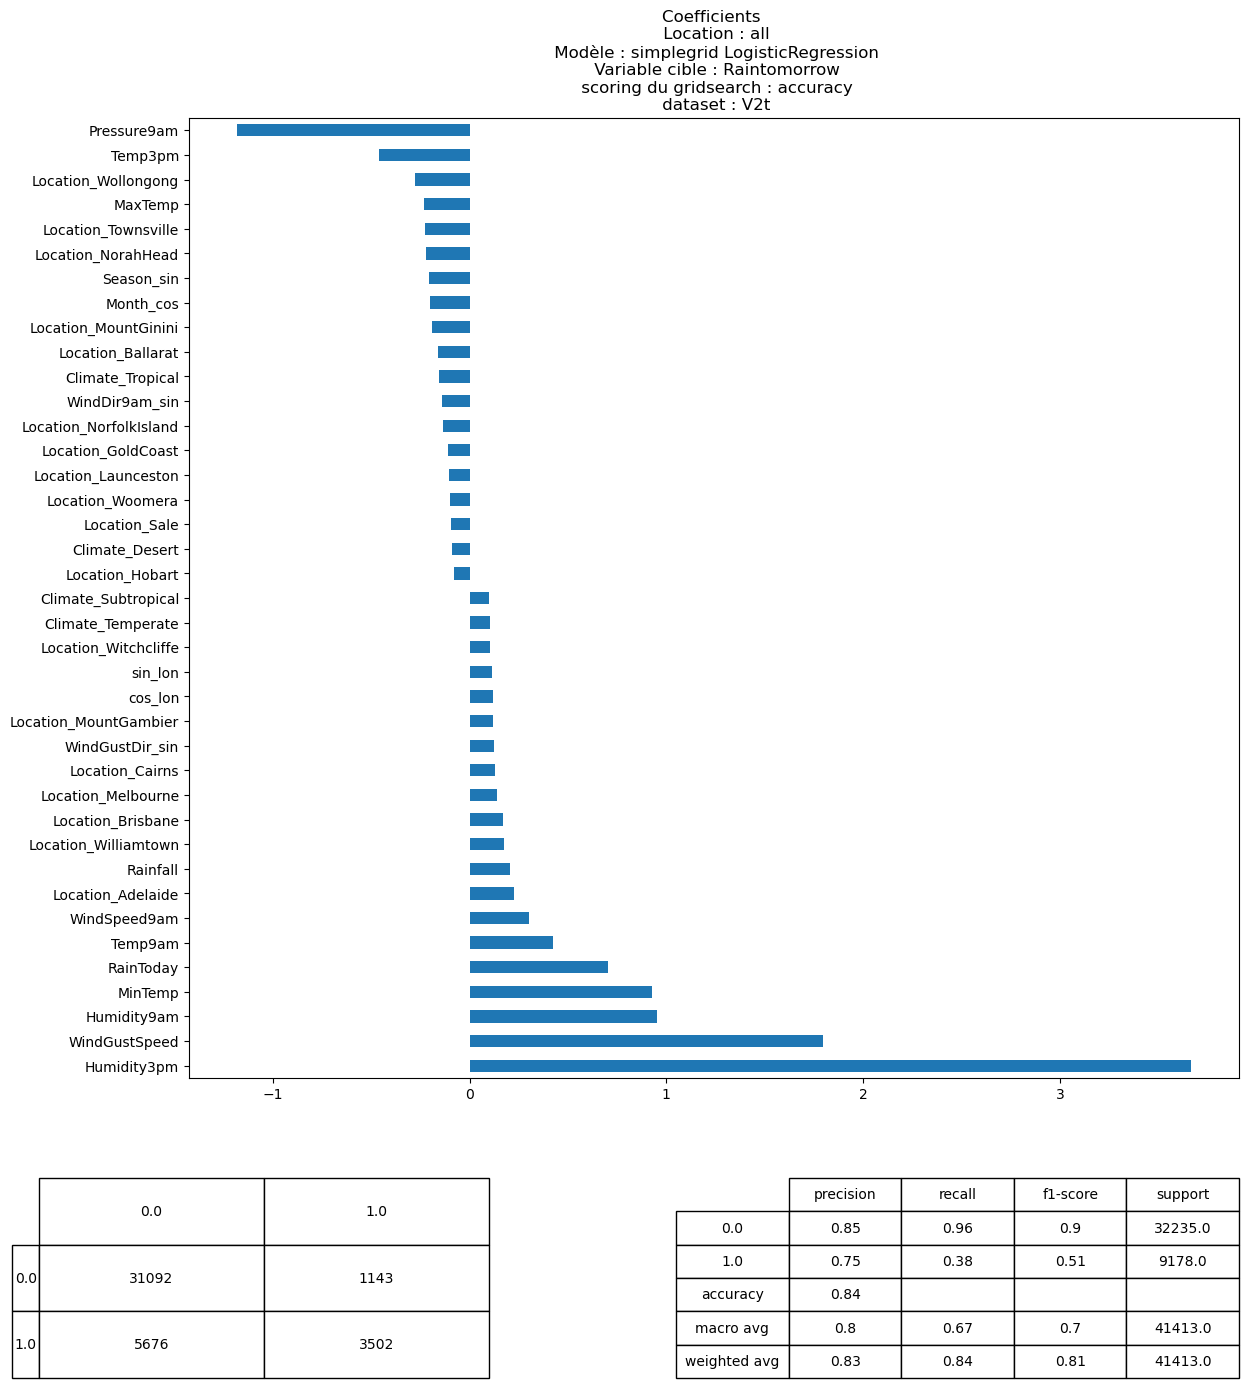

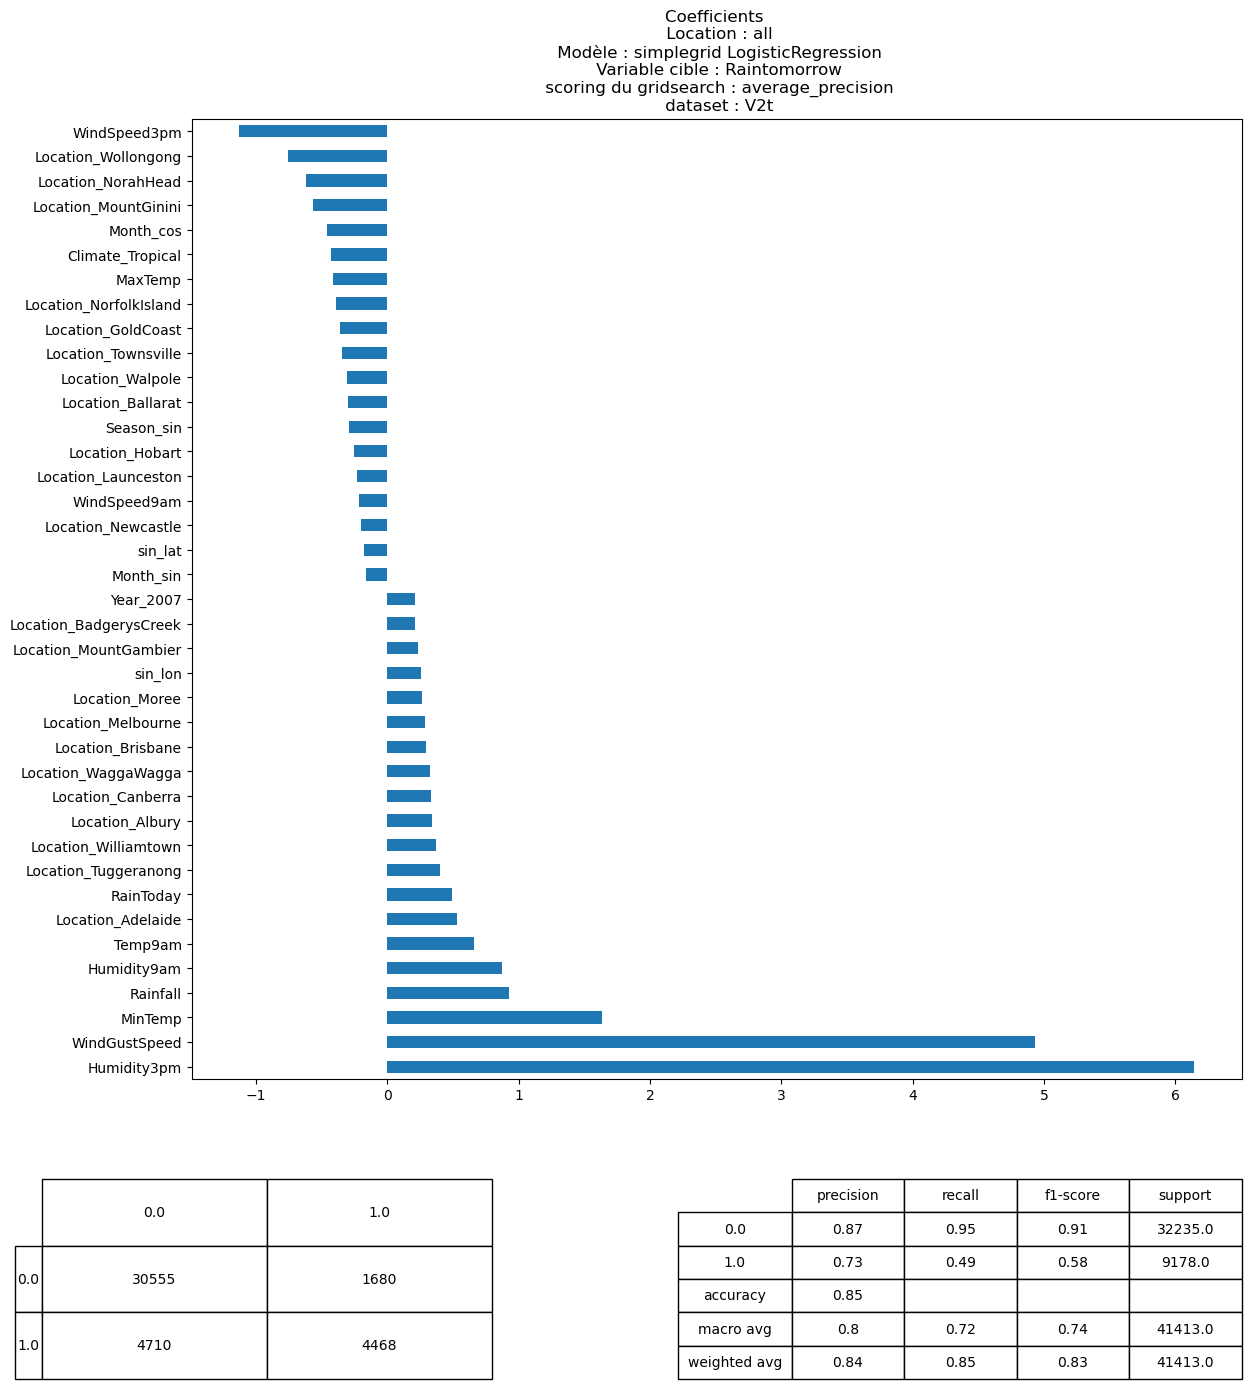

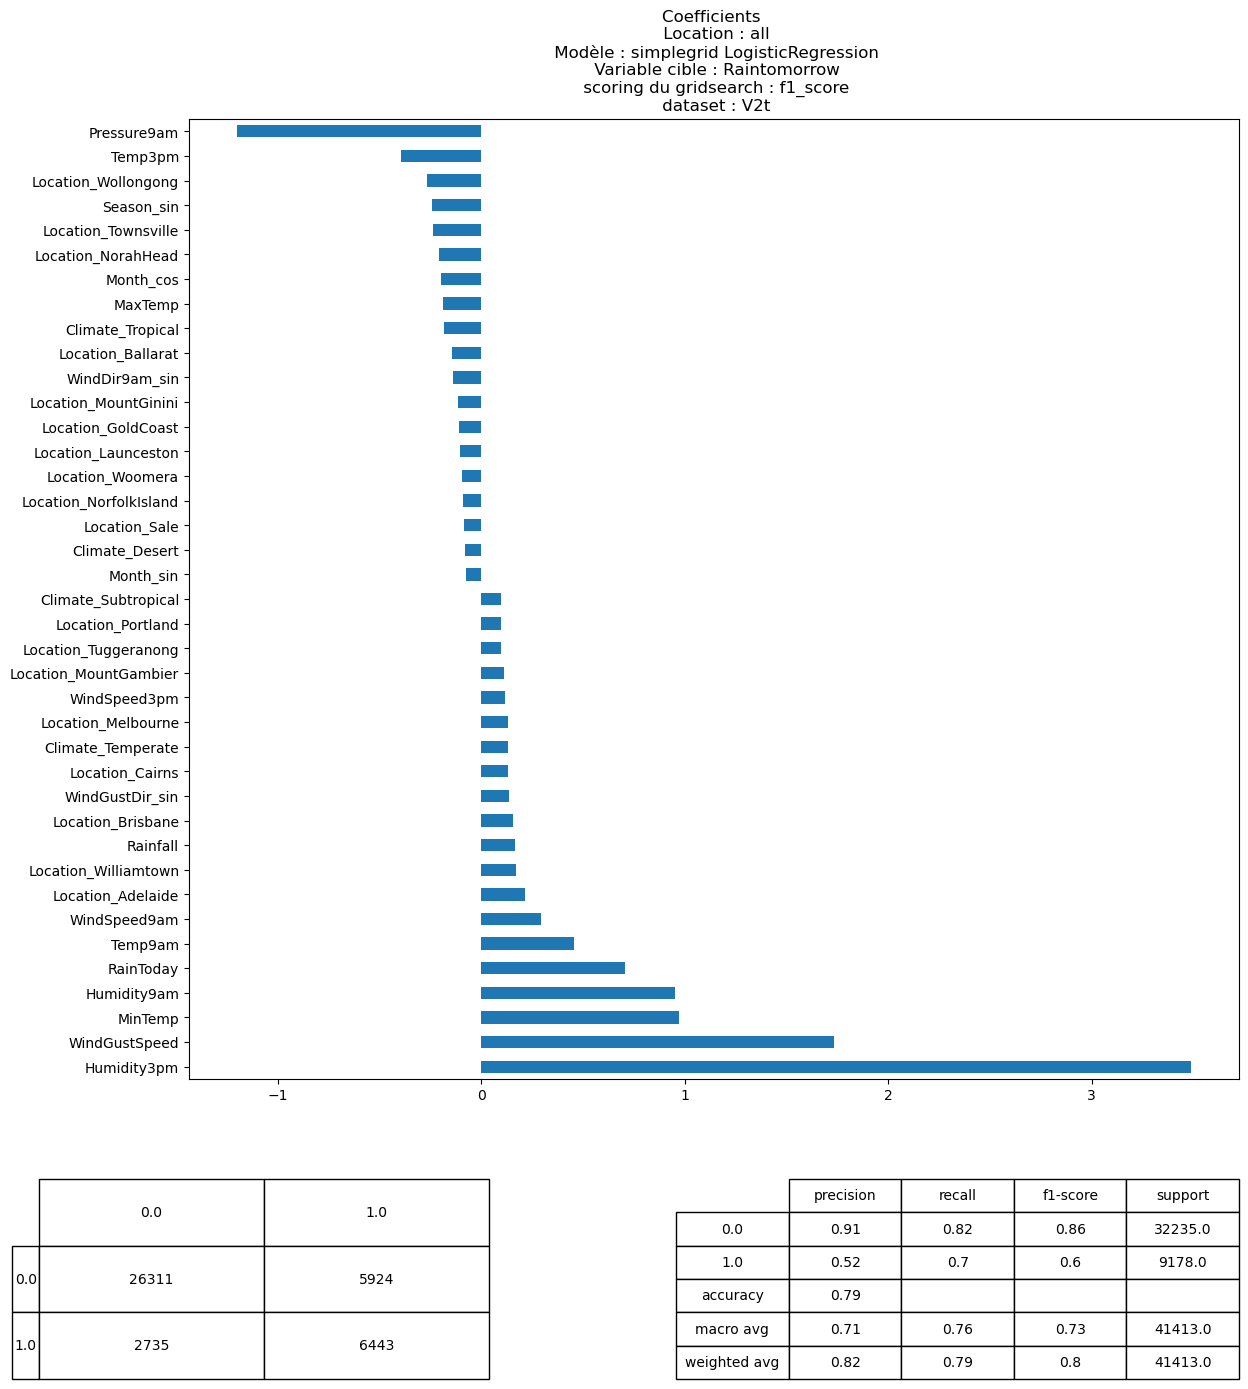

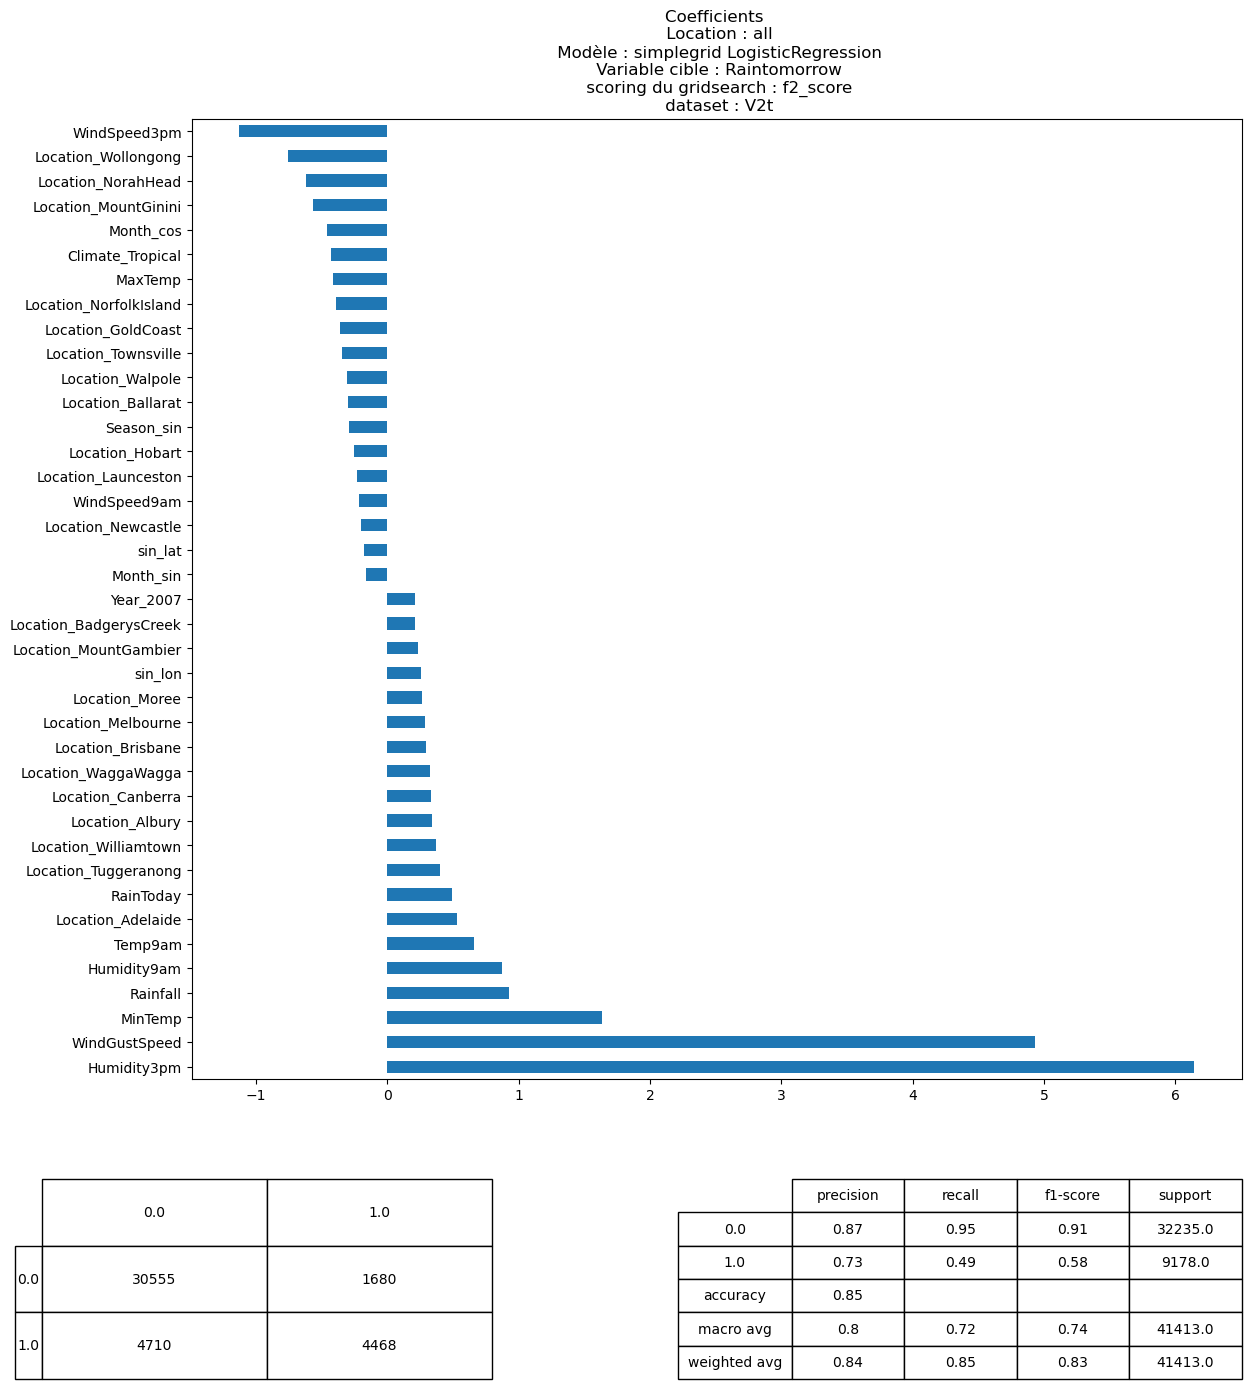

In [ ]:
# tuning LR basique sur V2
model_name = 'LogisticRegression'
model = LogisticRegression(max_iter=500, n_jobs=-1)
dataset = "V2t"
modeling_batch = "simplegrid"

# métriques de grid search
grid_metrics = {"accuracy" : make_scorer(accuracy_score),
                "average_precision" : make_scorer(average_precision_score),
                "f1_score" : make_scorer(f1_score), 
                "f2_score" : make_scorer(fbeta_score, beta=0.5, pos_label=1)}

variable_cible = "Raintomorrow"
param_grids = param_grids1
n_coef_graph = 40

X_train_search, X_test_search, y_train_search,  y_test_search = \
    X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t,  y_test_V2t


mf.modeling_global(model_name, model, dataset, modeling_batch, param_grids,
                    grid_metrics, variable_cible, n_coef_graph,
                    X_train_search, X_test_search, y_train_search, y_test_search)
    


Métrique de recherche : accuracy
Optimizing LogisticRegression


GridSearchCV
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting  LogisticRegression_tuned


Nom du modèle : LogisticRegression_tuned
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.87    0.95      0.91 29559.00
1.0                0.73    0.49      0.59  8367.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.80    0.72      0.75 37926.00
weighted avg       0.84    0.85      0.84 37926.00
Matrice de confusion :
       0.00  1.00
0.00  28066  1493
1.00   4249  4118
Métrique de recherche : average_precision
Optimizing LogisticRegression


GridSearchCV
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting  LogisticRegression_tuned


Nom du modèle : LogisticRegression_tuned
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.92    0.82      0.87 29559.00
1.0             

'GridSearchjFinished'

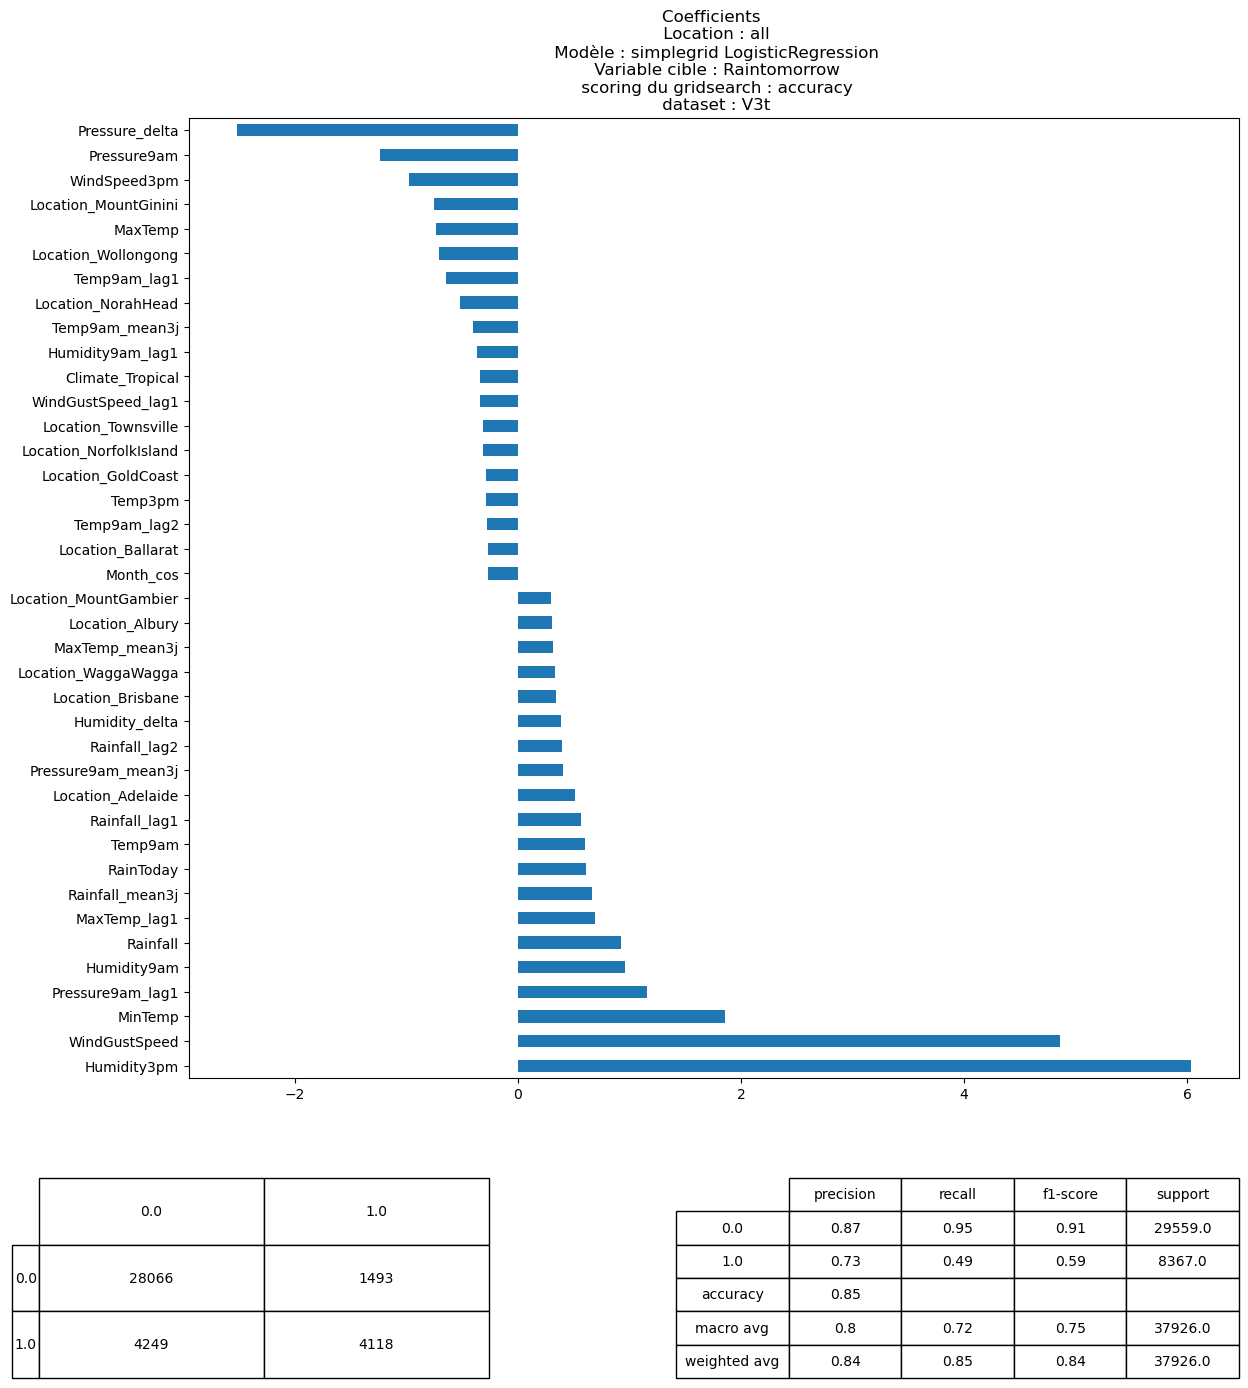

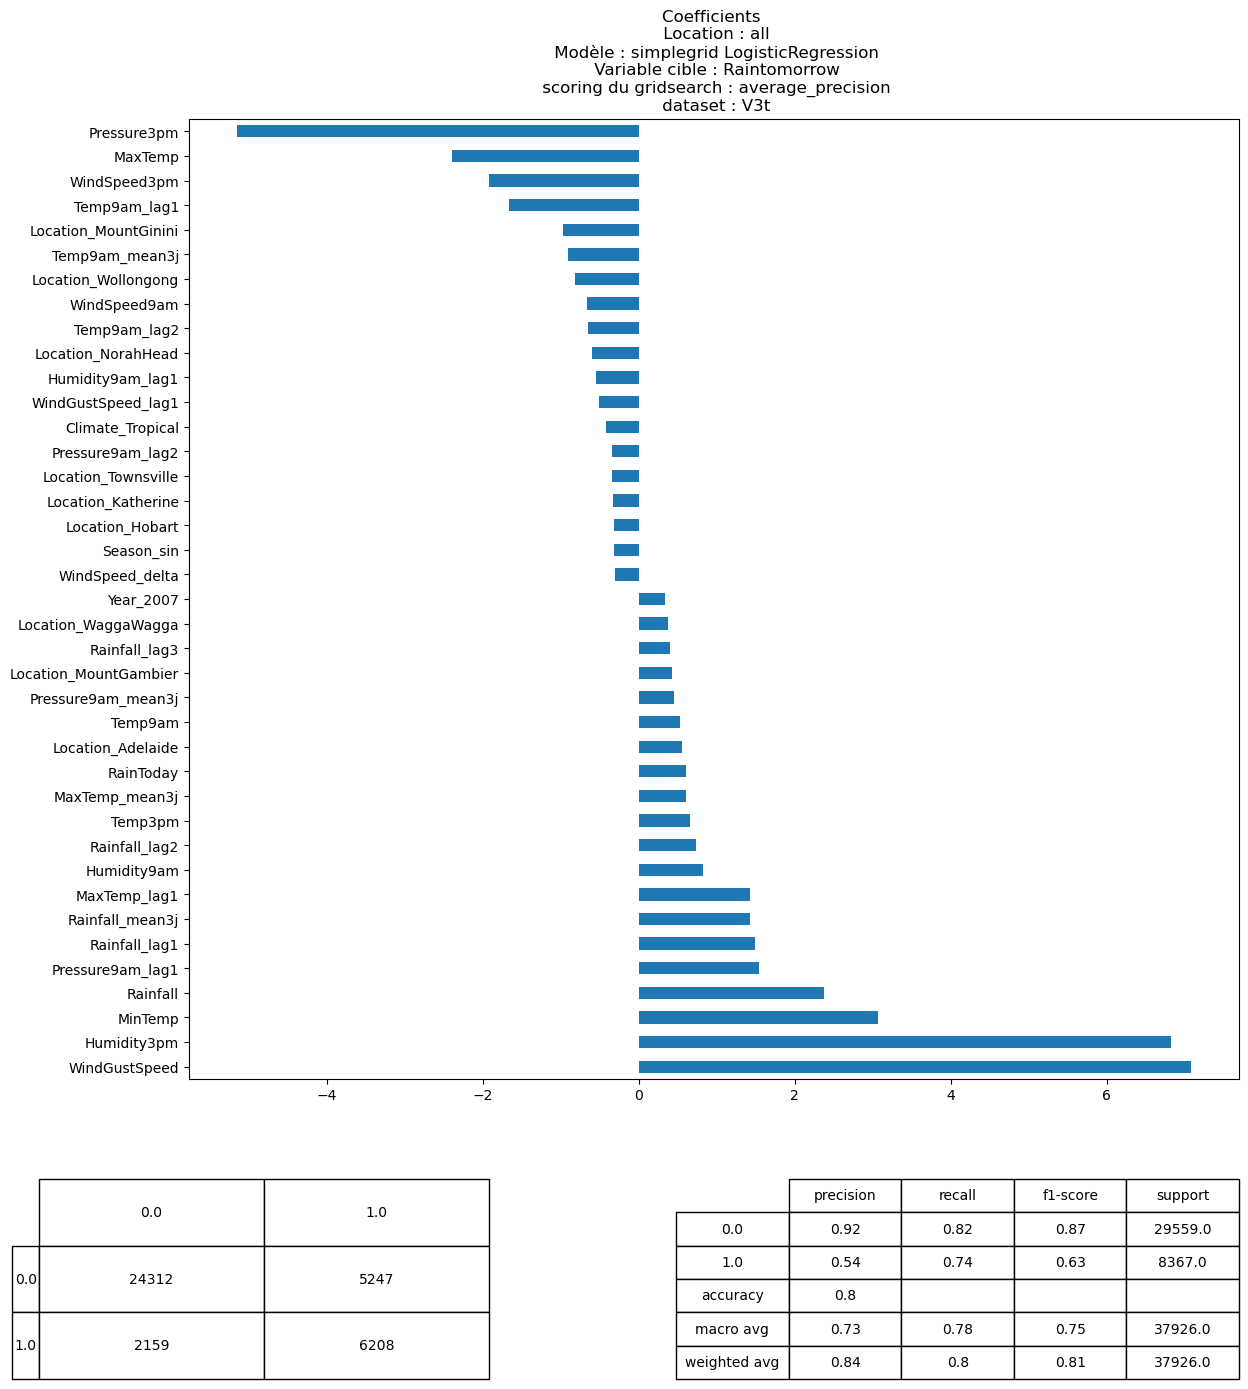

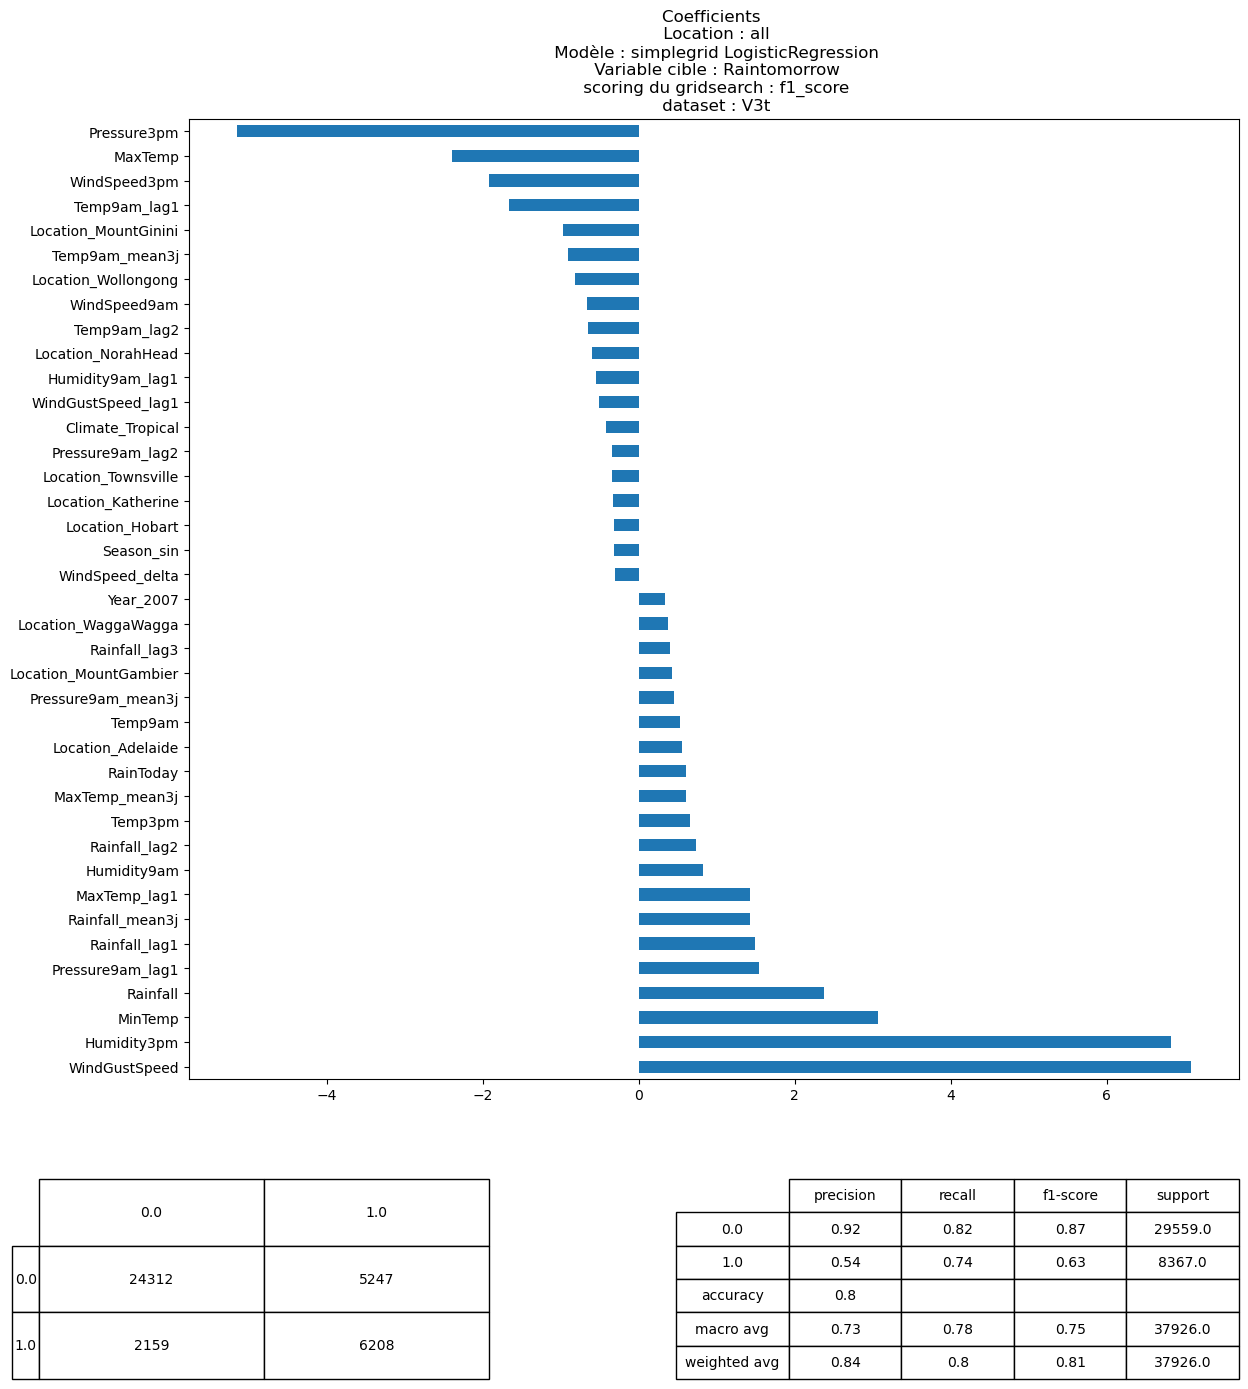

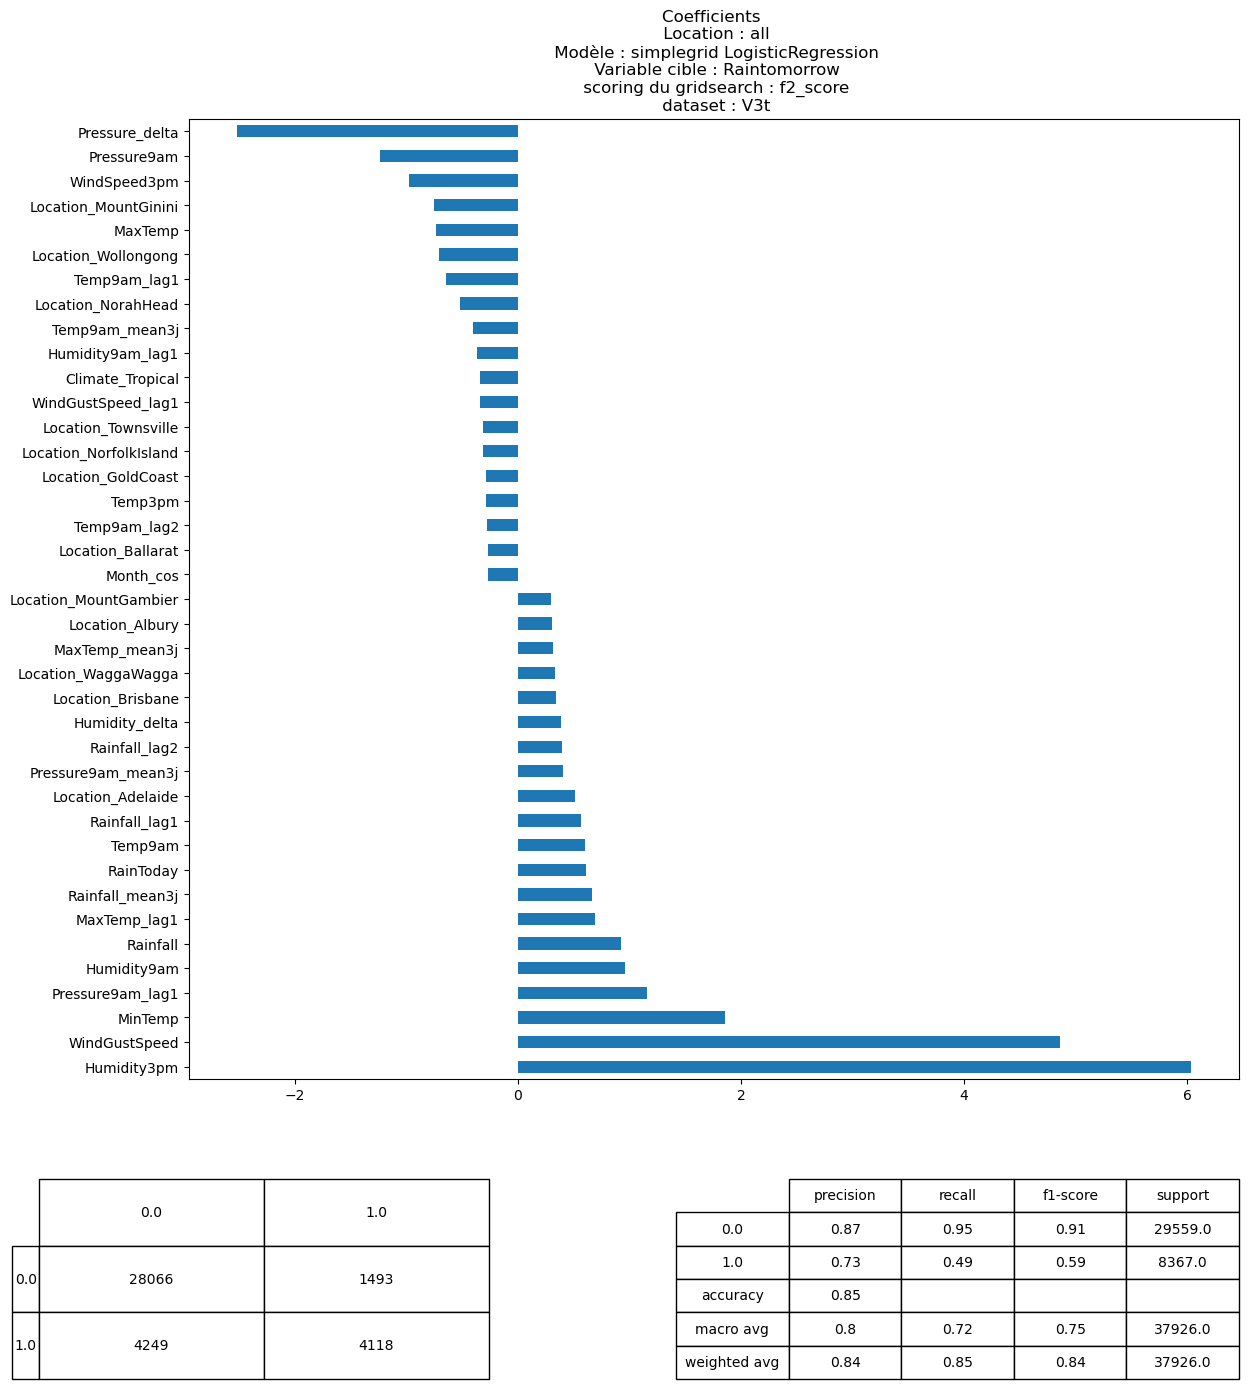

In [12]:
# tuning LR basique sur données V3
model_name = 'LogisticRegression'
model = LogisticRegression(max_iter=500, n_jobs=-1)
dataset = "V3t"
modeling_batch = "simplegrid"

# métriques de grid search
grid_metrics = {"accuracy" : make_scorer(accuracy_score),
                "average_precision" : make_scorer(average_precision_score),
                "f1_score" : make_scorer(f1_score), 
                "f2_score" : make_scorer(fbeta_score, beta=0.5, pos_label=1)}

variable_cible = "Raintomorrow"
param_grids = param_grids1
n_coef_graph = 40

X_train_search, X_test_search, y_train_search,  y_test_search = \
    X_train_V3t_scaled, X_test_V3t_scaled, y_train_V3t,  y_test_V3t


mf.modeling_global(model_name, model, dataset, modeling_batch, param_grids,
                    grid_metrics, variable_cible, n_coef_graph,
                    X_train_search, X_test_search, y_train_search, y_test_search)
    

# 2) Tuning LR, grille de paramètres plus large

Métrique de recherche : accuracy
Optimizing LogisticRegression


GridSearchCV
Fitting 3 folds for each of 2400 candidates, totalling 7200 fits
Fitting  LogisticRegression_tuned


Nom du modèle : LogisticRegression_tuned
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.86    0.95      0.90 32235.00
1.0                0.73    0.44      0.55  9178.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.79    0.70      0.73 41413.00
weighted avg       0.83    0.84      0.82 41413.00
Matrice de confusion :
       0.00  1.00
0.00  30766  1469
1.00   5154  4024
Métrique de recherche : average_precision
Optimizing LogisticRegression


GridSearchCV
Fitting 3 folds for each of 2400 candidates, totalling 7200 fits
Fitting  LogisticRegression_tuned


Nom du modèle : LogisticRegression_tuned
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.86    0.95      0.90 32235.00
1.0       

'GridSearchjFinished'

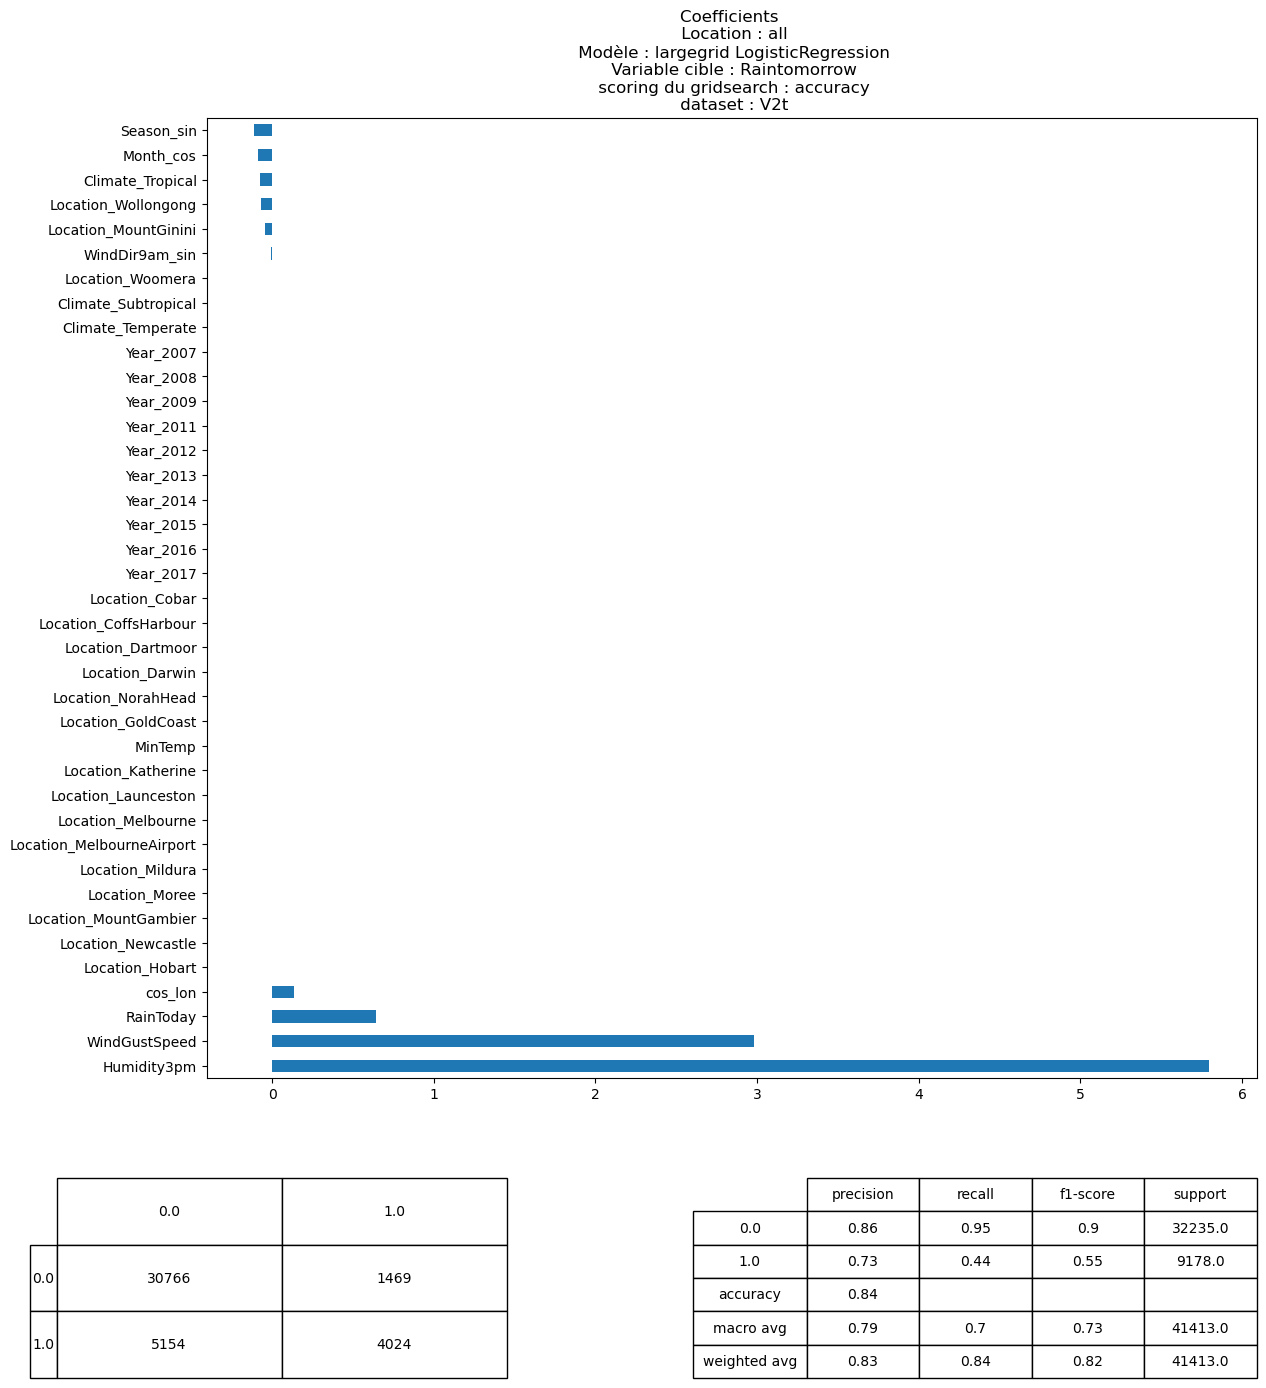

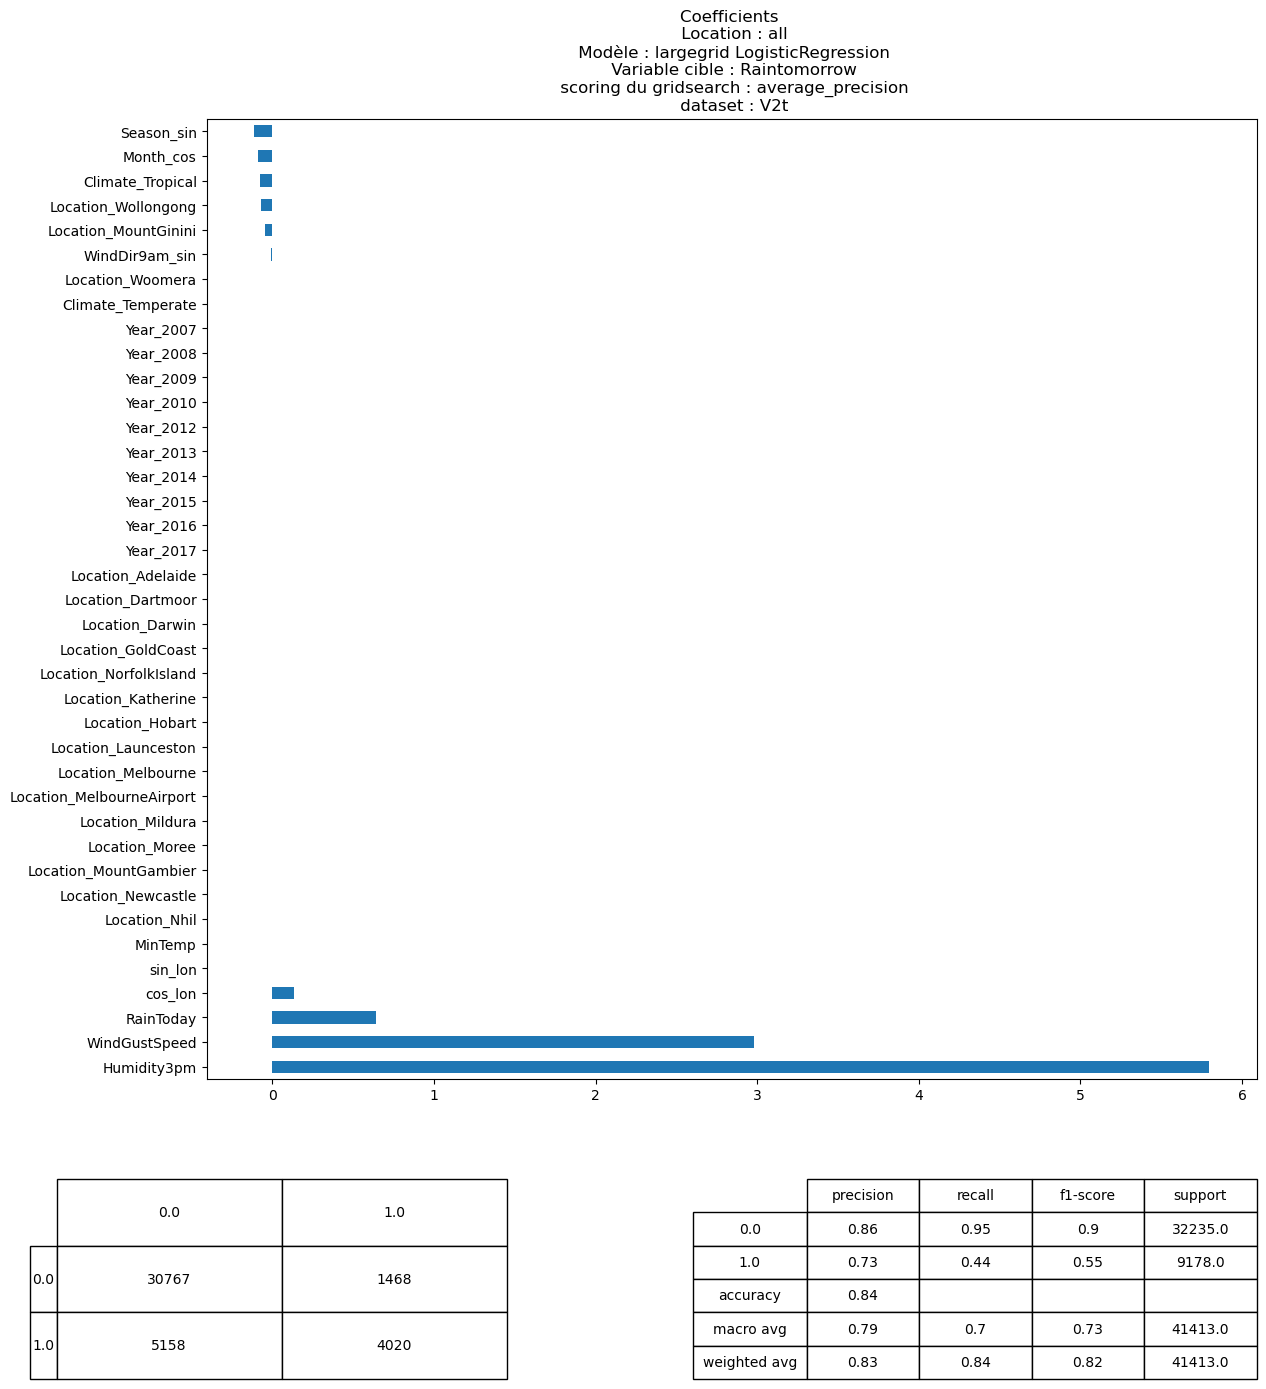

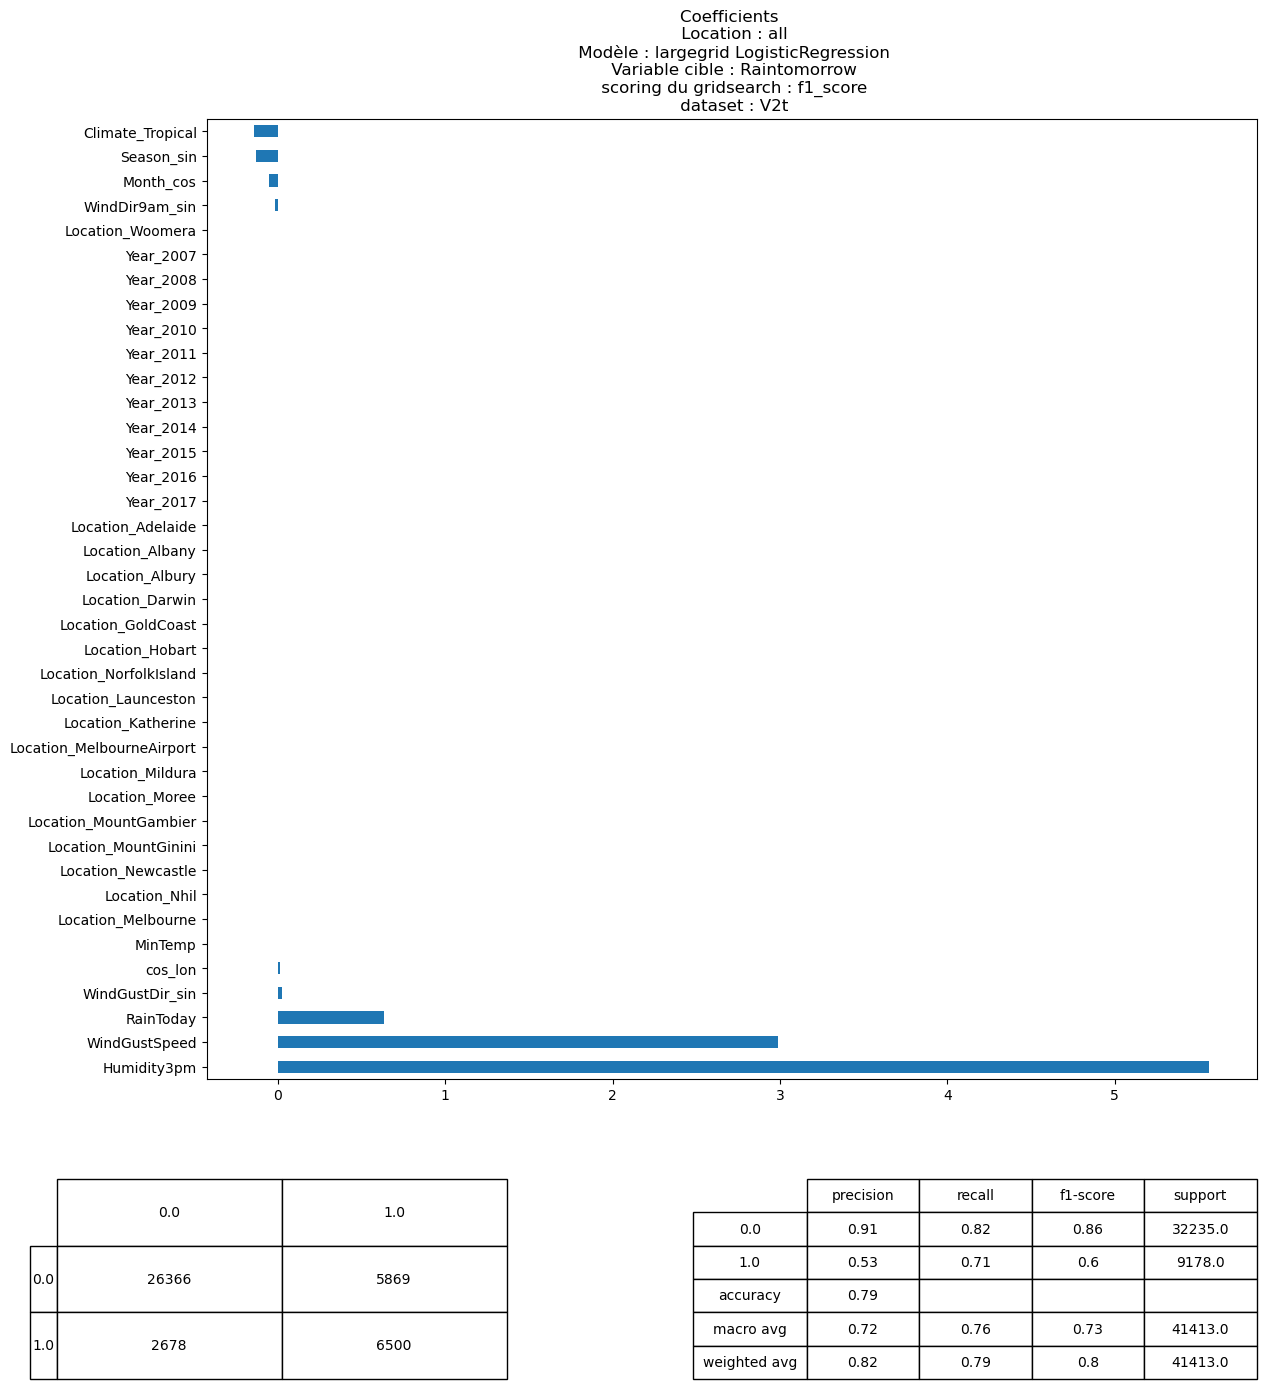

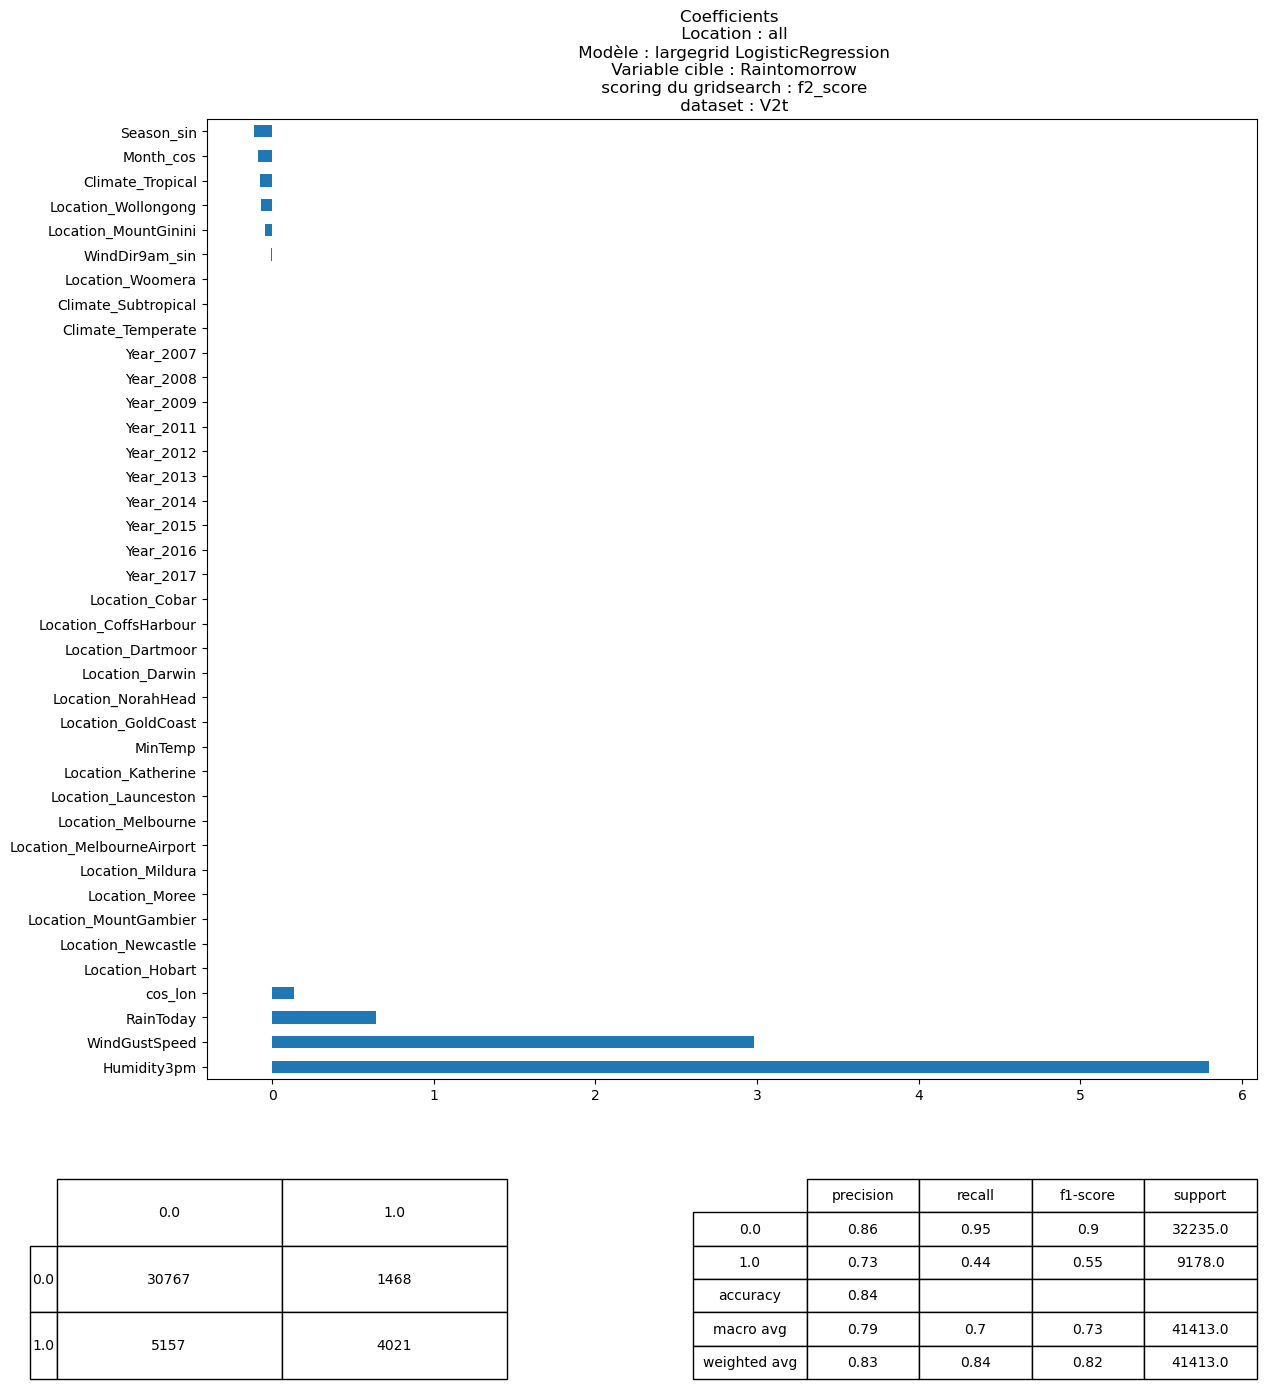

In [13]:
# tuning LR plus large (param_grids2) sur V2 (prend 120 min)
model_name = 'LogisticRegression'
model = LogisticRegression(max_iter=500, n_jobs=-1)
dataset = "V2t"
modeling_batch = "largegrid"

# métriques de grid search
grid_metrics = {"accuracy" : make_scorer(accuracy_score),
                "average_precision" : make_scorer(average_precision_score),
                "f1_score" : make_scorer(f1_score), 
                "f2_score" : make_scorer(fbeta_score, beta=0.5, pos_label=1)}

variable_cible = "Raintomorrow"
param_grids = param_grids2
n_coef_graph = 40

X_train_search, X_test_search, y_train_search,  y_test_search = \
    X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t,  y_test_V2t


mf.modeling_global(model_name, model, dataset, modeling_batch, param_grids,
                    grid_metrics, variable_cible, n_coef_graph,
                    X_train_search, X_test_search, y_train_search, y_test_search)
    

# Analyse de l'impact des paramètres du gridsearch

{'LogisticRegression': {'GridSearchCV': {'best_params': {'C': 0.01, 'class_weight': {0: 0.495, 1: 0.505}, 'fit_intercept': True, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}, 'best_cv_score': 0.8336972228374943, 'test_accuracy': 0.8400260787675368, 'test_f1_score': 0.5483057203245381, 'test_precision': 0.7325560211331754, 'test_recall': 0.43811287862279363}}}
LogisticRegression(C=0.01, class_weight={0: 0.495, 1: 0.505}, max_iter=500,
                   n_jobs=-1, penalty='l1', solver='saga')
0.8336972228374943
      mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0              0.04          0.00             0.00            0.00     0.00   
1              0.04          0.00             0.00            0.00     0.00   
2              0.04          0.00             0.00            0.00     0.00   
3              0.04          0.00             0.00            0.00     0.00   
4              0.05          0.01             0.00            0.00     0.00   
...

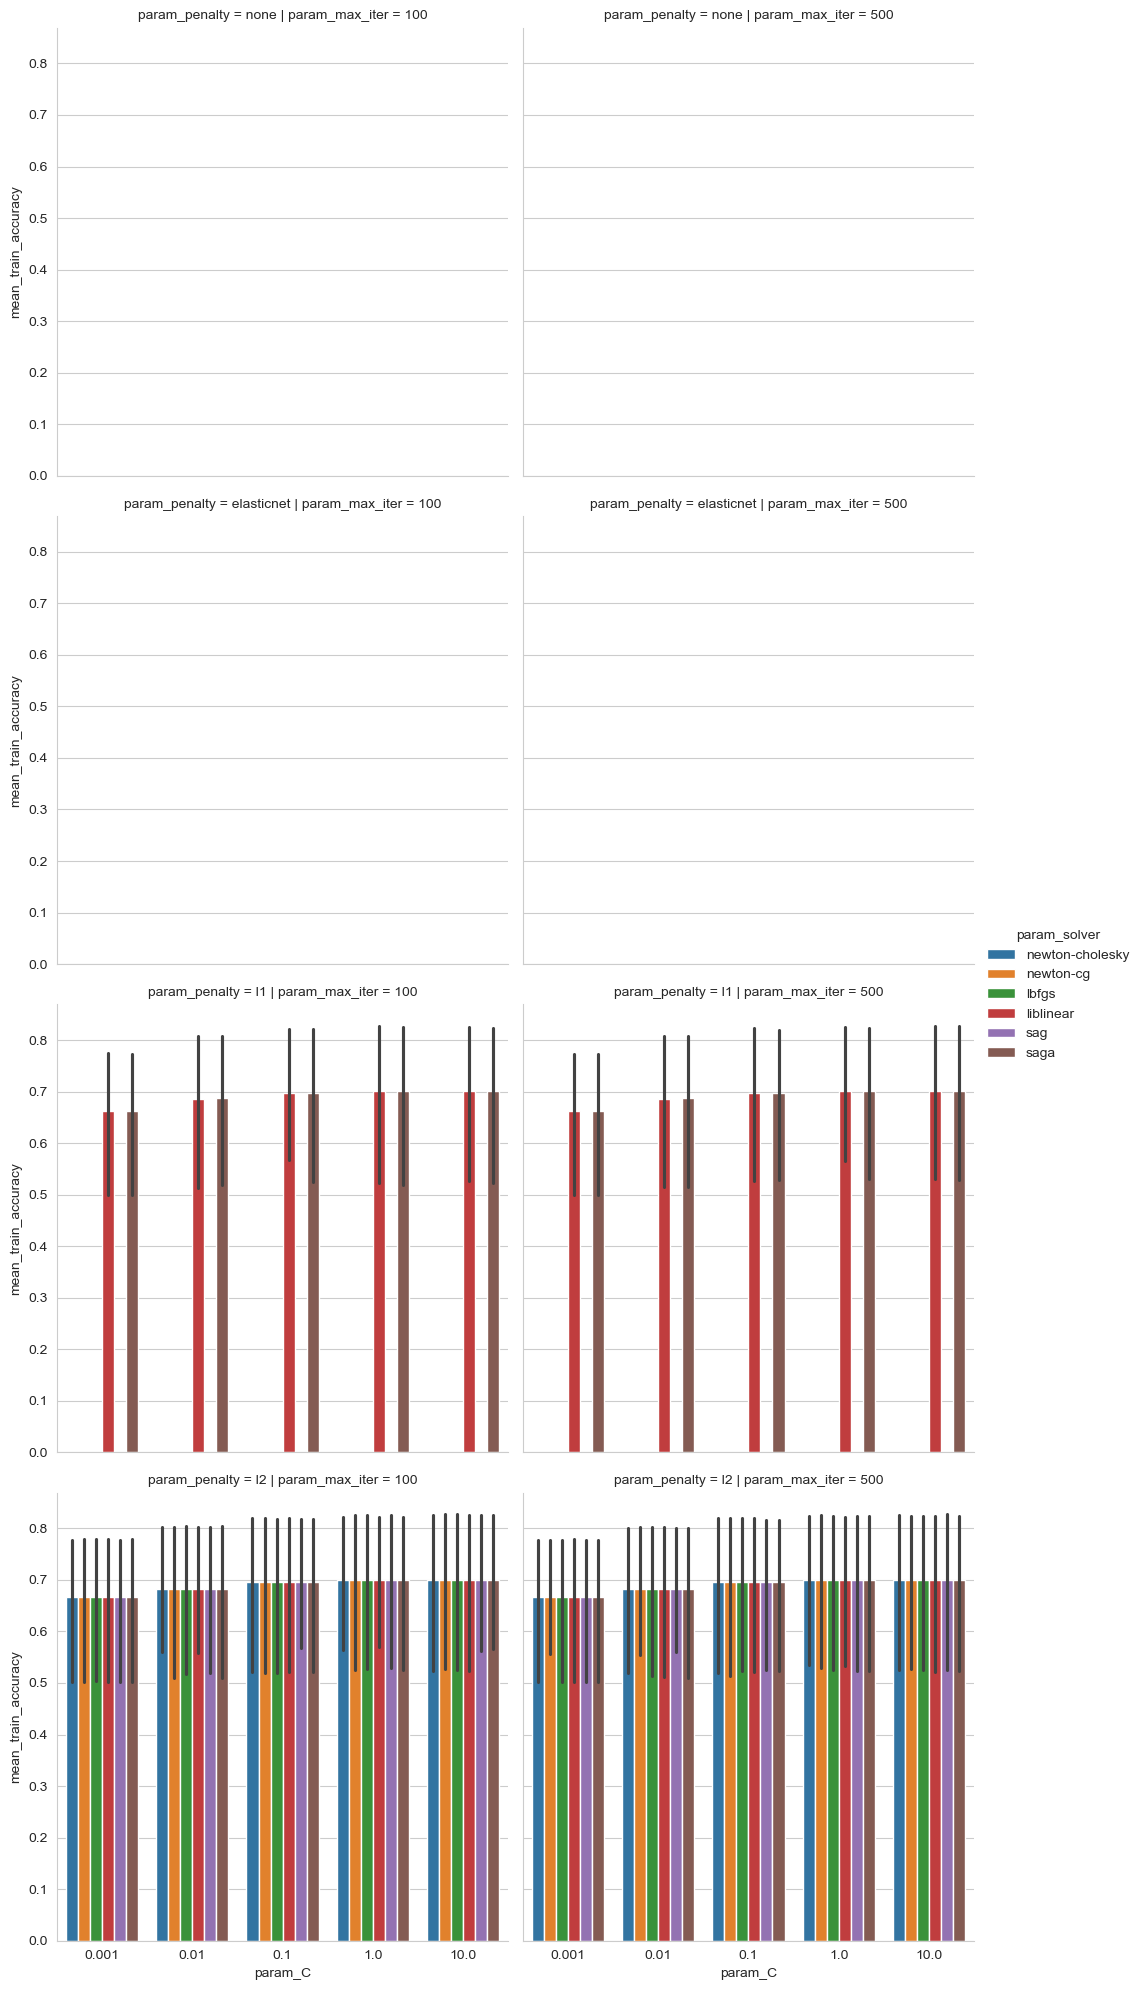

In [ ]:
print(results_search_lr3)
print(search_lr3.best_estimator_)
print(search_lr3.best_score_)

table_results = pd.DataFrame(search_lr3.cv_results_)
sns.catplot(x = table_results["param_C"], 
            y = table_results["mean_train_accuracy"], 
            kind = "bar",
             hue = table_results["param_solver"], 
             row = table_results["param_penalty"],
             col = table_results["param_max_iter"])

# Tuning RandomForest et Balanced RandomForest

In [ ]:
# tuning simple sur V2

model_list ={
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1),
    'BalancedRandomForestClassifier': BalancedRandomForestClassifier(n_jobs=-1)
}

dataset = "V2t"
modeling_batch = "simplegrid"
# métriques de grid search
grid_metrics = {"accuracy" : make_scorer(accuracy_score),
                "average_precision" : make_scorer(average_precision_score),
                "f1_score" : make_scorer(f1_score), 
                "f2_score" : make_scorer(fbeta_score, beta=0.5, pos_label=1)}
variable_cible = "Raintomorrow"
param_grids = param_grids1
n_coef_graph = 40

X_train_search, X_test_search, y_train_search,  y_test_search = \
    X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t,  y_test_V2t

for model_name, model in model_list.items() : 

    mf.modeling_global(model_name, model, dataset, modeling_batch, param_grids,
                        grid_metrics, variable_cible, n_coef_graph,
                        X_train_search, X_test_search, y_train_search, 
                        y_test_search)


Métrique de recherche : accuracy
Optimizing RandomForestClassifier


GridSearchCV
Fitting 3 folds for each of 135 candidates, totalling 405 fits
